In [1]:
# Imports
from dataclasses import dataclass
from functools import cached_property
import lsst.daf.butler as dafButler
import lsst.geom as geom

import numpy as np
import pandas as pd

In [2]:
# Setup for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['image.origin'] = 'lower'
sns.set(rc={'axes.facecolor': '0.85', 'figure.facecolor': 'w'})

In [3]:
# Load data and setup column lists
weekly = 'w_2022_10'
ticket = 'DM-33905'
# Not sure if this should be a dimension - anyway, it's in the match configs
model = 'cModel'

butlers = tuple(
    dafButler.Butler(
        '/repo/dc2',
        collections=[
            # '2.2i/truth_summary',
            # Not needed currently - will be when with task is run in $OBS_LSST_DIR/pipelines/DRP.yaml
            # f'2.2i/runs/test-med-1/{weekly}/{ticket}',
            collection,
        ]
    )
    for collection in (
        f'u/dtaranu/DM-33221/w_2022_10/diff',
        f'u/dtaranu/DM-33221/w_2022_10/diff_01',
    )
)

tracts = (3828,) # 3829)
bands = 'ugrizy'

In [4]:
# Load stat catalogs
@dataclass(frozen=True)
class Data:
    data: pd.DataFrame
    
    @cached_property
    def n_bins(self):
        return len(self.data)
    
    @cached_property
    def x(self):
        x = np.zeros(self.n_bins + 1)
        x[:-1] = self.data['mag_min']
        x[-1] = self.data['mag_max'].values[-1]
        return x

data_bins = tuple(
    Data(butler.get('diff_matched_truth_summary_objectTable_tract', tract=tracts[0], skymap='DC2'))
    for butler in butlers
)

In [5]:
# Setup labels and definitions for plots
name_n = '_n'
label_all = 'All'
label_ref = 'Reference'
label_target = 'Measured'
sizes = {'All': '', 'Resolved': '_resolved', 'Unresolved': '_unresolved'}
types = {label_ref: '_ref', label_target: '_target'}
types_plot = {label_ref: 'Completeness', label_target: 'Purity'}
label_right = 'Right'
label_wrong = 'Wrong'
matches = {label_right: '_match_right', label_wrong: '_match_wrong'}

In [6]:
# Define plotting methods
def plot_compurity(x, n_matched_type, n_source, label_size, label_right, label_wrong,
                   label_x, label_y, label_title, model, tract):
    plt.stairs(np.sum(list(n_matched_type.values()), axis=0)/n_source, x, label=label_size)
    plt.stairs(n_matched_type[label_right]/n_source, x, label=label_right)
    plt.stairs(n_matched_type[label_wrong]/n_source, x, label=label_wrong)
    plt.ylim(0, 1.01)
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.legend()
    plt.title(f'Tract={tract}, N{label_title}={np.sum(n_source)}, {model}, {label_size}')

def plot_compurity_all(data_obj: Data, bands, sizes, types, matches, tract):
    data = data_obj.data
    n_bins = data_obj.n_bins
    for band in bands:
        # Plot all, resolved and unresolved sources separately
        print(f'{band} band')
        for label_size, name_size in sizes.items():
            print(f'{band} band, {label_size}')
            # Sum together various finely aggregated columns
            if label_size == label_all:
                n_type = {label: np.zeros(n_bins, dtype=np.int64) for label in types.keys()}
                n_matched = {
                    label_type: {label: np.zeros(n_bins, dtype=np.int64) for label in matches.keys()}
                    for label_type in types.keys()
                }
                for name_size_other in (n for l_other, n in sizes.items() if l_other != label_all):
                    for label_type, name_type in types.items():
                        if label_type != label_all:
                            n_type[label_type] += np.sum([
                                data[f'{band}{name_size_other}{name_n}{name_type}'].values         
                            ], axis=0)
                        for label_match, name_match in matches.items():
                            n_matched[label_type][label_match] += np.sum([
                                data[f'{band}{name_size_other}{name_n}{name_type}{name_match}'].values
                            ], axis=0)
            else:
                n_type = {label: data[f'{band}{name_size}{name_n}{name}'].values for label, name in types.items()}
                n_matched = {
                    label_type: {
                        label: data[f'{band}{name_size}{name_n}{name_type}{name}'].values
                        for label, name in matches.items()
                    }
                    for label_type, name_type in types.items()
                }

            for label_type, n_source in n_type.items():
                print(f'{band} band, {label_size}, {label_type}')
                plot_compurity(data_obj.x, n_matched_type=n_matched[label_type], n_source=n_source,
                               label_size=label_size, label_right=label_right, label_wrong=label_wrong,
                               label_x=band, label_y=types_plot[label_type], label_title=types[label_type],
                               model=model, tract=tract)
                plt.show()

In [7]:
# Definitions for diffs/chis
# achromatic measures, i.e. don't depend on band
measures_achrom = ('x', 'y', 'dr')
def get_measures_band(band, model, band_prev=None):
    measures_band = [
        f'flux_{band}_{model}Flux',
        f'mag_{band}_{model}Flux',
    ]
    if band_prev is not None:
        measures_band.extend([
            f'color_{band_prev}-{band}_{band}_cModelFlux',
        ])
    return tuple(measures_band)

label_diff = 'Model - Data'
label_chi = 'Chi = (Model - Data)/Error'

scales = {label_diff: '', label_chi: '_chi'}
stats = {
    'Median': '_median',
    '$\sigma_{IQR}$': '_sig_iqr',
    '$\sigma_{MAD}$': '_sig_mad',
    '5%ile': '_p05',
    '16%ile': '_p16',
    '84%ile': '_p84',
    '95%ile': '_p95',
}

def plot_diffs_all(data_obj: Data, bands, scales, measures_achrom, stats, model):
    x = data_obj.x
    data = data_obj.data
    band_prev = None
    for band in bands:
        # Plot all, resolved and unresolved sources separately
        print(f'{band} band')
        for label_scale, name_scale in scales.items():
            for measures in (measures_achrom, get_measures_band(band, model, band_prev)):
                for measure in measures:
                    found = False
                    for label_stat, name_stat in stats.items():
                        column = f'{band}_{measure}{name_scale}{name_stat}'
                        if column in data.columns:
                            found = True
                            plt.stairs(data[column].values, x, label=label_stat)
                        else:
                            print(f"Didn't find {column}")
                    if found:
                        plt.xlabel(f'{band}')
                        plt.ylabel(label_scale)
                        if label_scale == label_chi:
                            plt.ylim((-10, 10))
                        plt.legend()
                        plt.title(f'{measure}')
                        plt.show()
        band_prev = band

u band
u band, All
u band, All, Reference


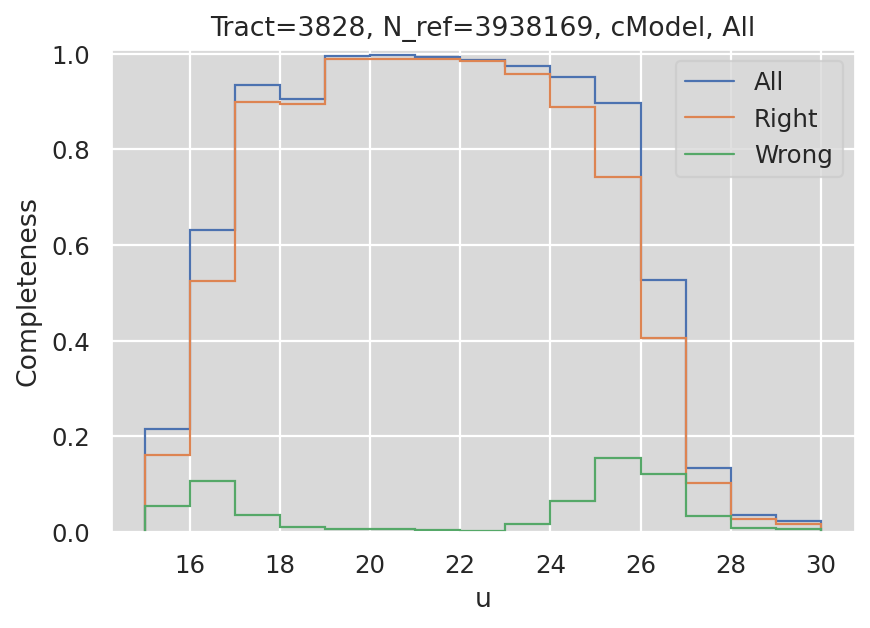

u band, All, Measured


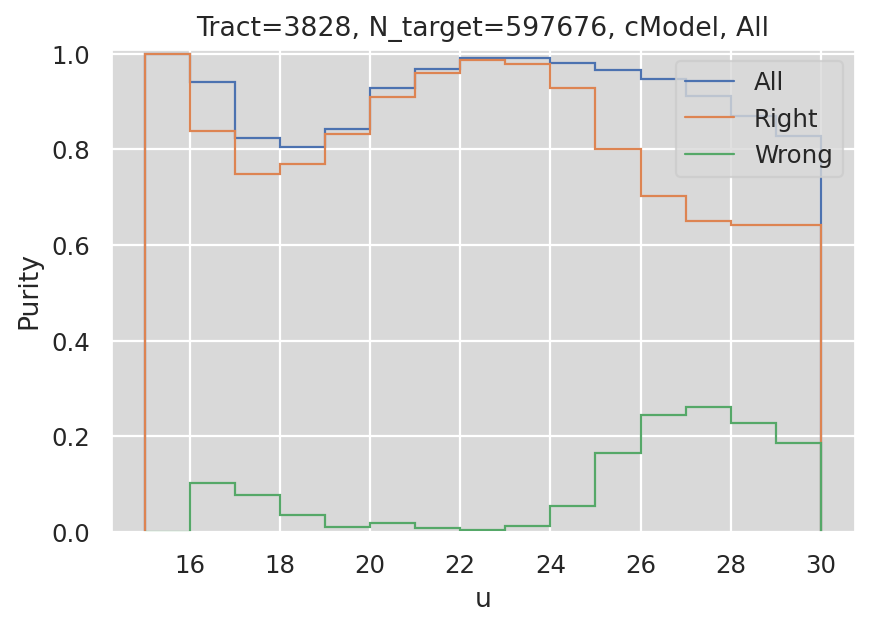

u band, Resolved
u band, Resolved, Reference


/tmp/ipykernel_1591751/1663157381.py:4: RuntimeWarning: invalid value encountered in true_divide
  plt.stairs(np.sum(list(n_matched_type.values()), axis=0)/n_source, x, label=label_size)
/tmp/ipykernel_1591751/1663157381.py:5: RuntimeWarning: invalid value encountered in true_divide
  plt.stairs(n_matched_type[label_right]/n_source, x, label=label_right)
/tmp/ipykernel_1591751/1663157381.py:6: RuntimeWarning: invalid value encountered in true_divide
  plt.stairs(n_matched_type[label_wrong]/n_source, x, label=label_wrong)


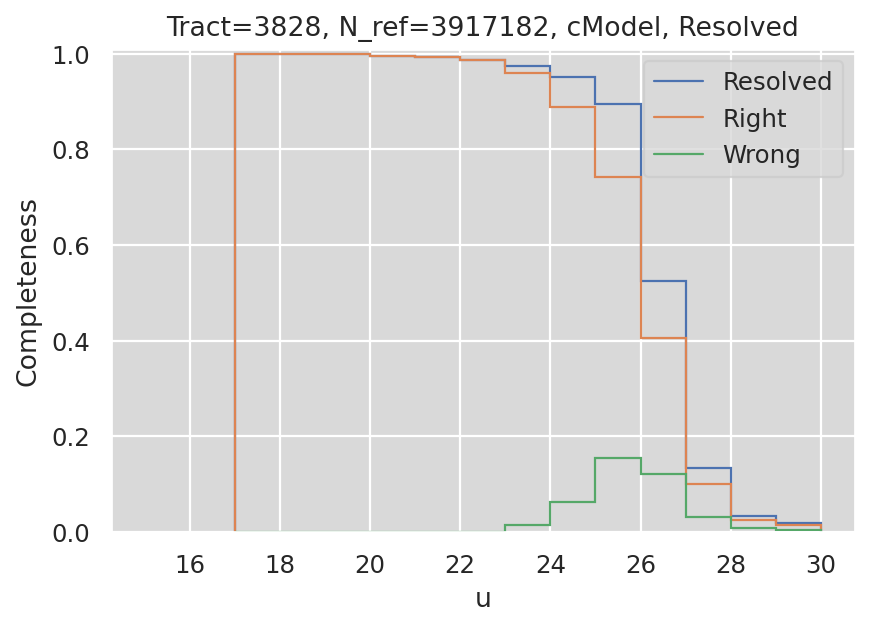

u band, Resolved, Measured


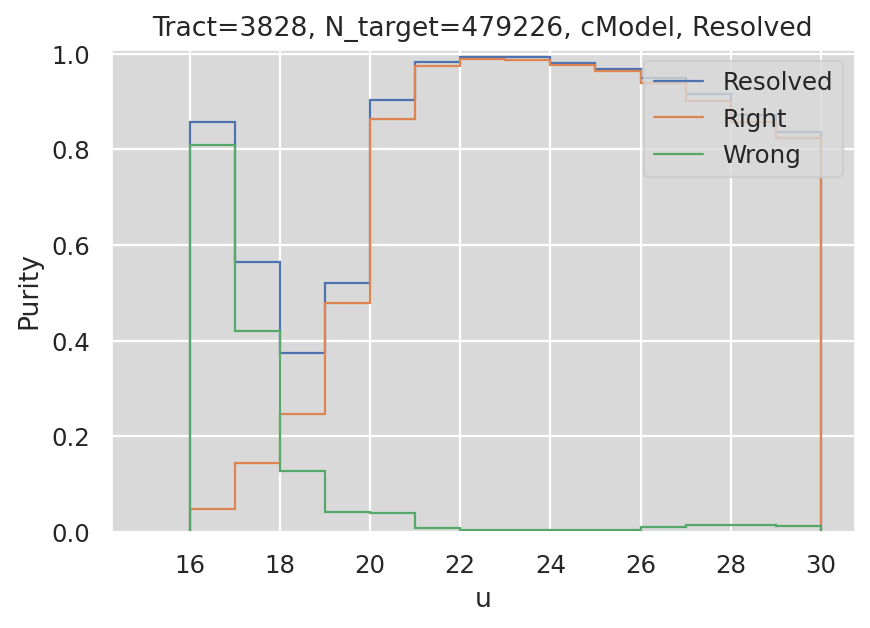

u band, Unresolved
u band, Unresolved, Reference


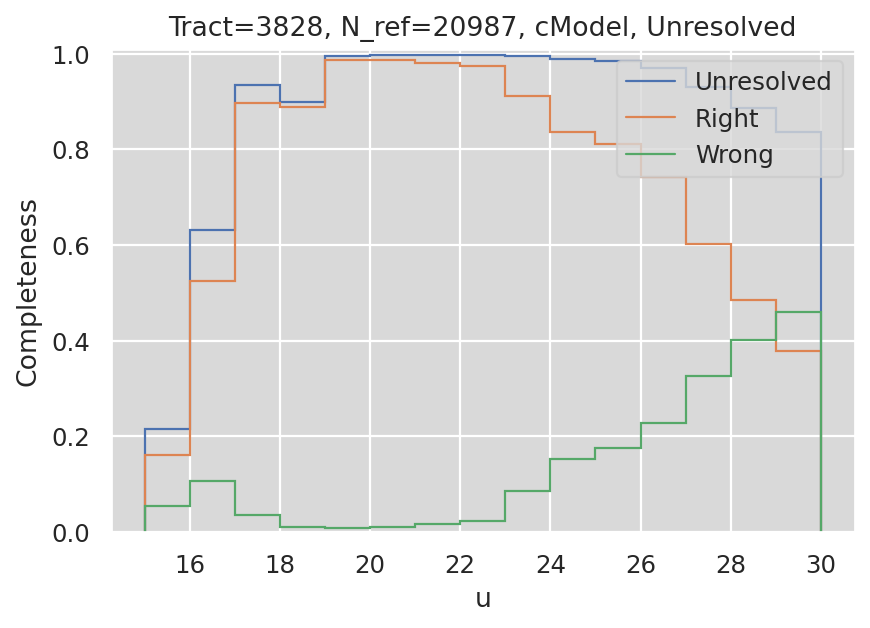

u band, Unresolved, Measured


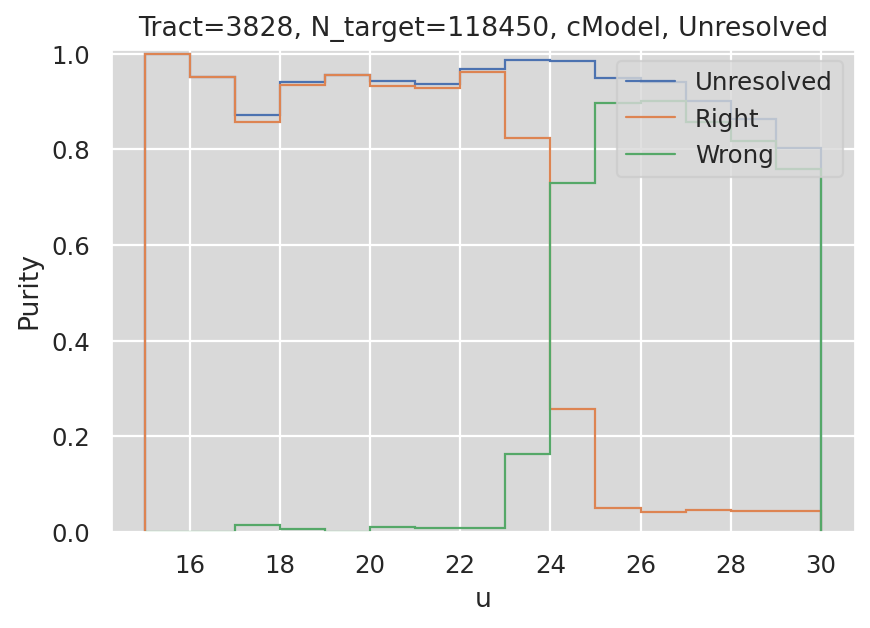

g band
g band, All
g band, All, Reference


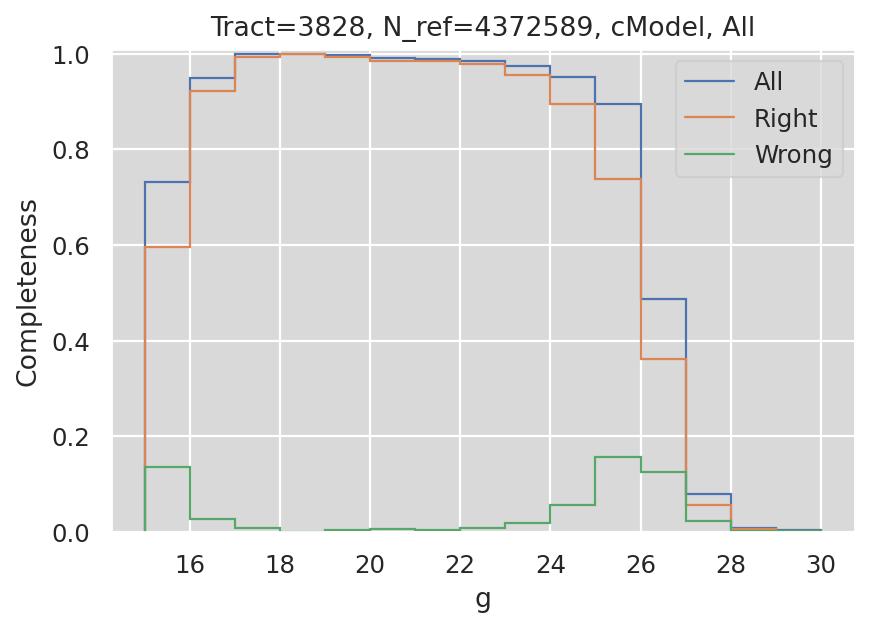

g band, All, Measured


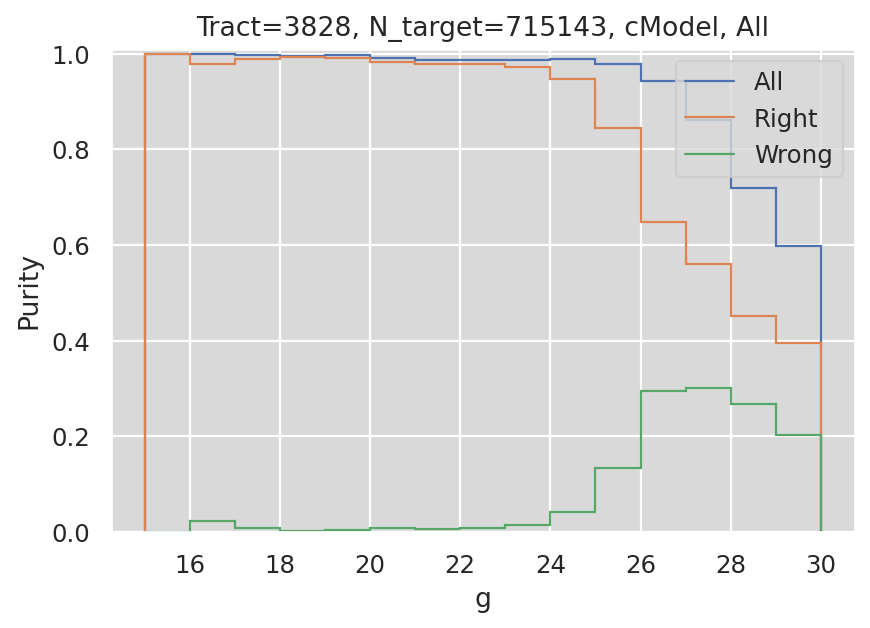

g band, Resolved
g band, Resolved, Reference


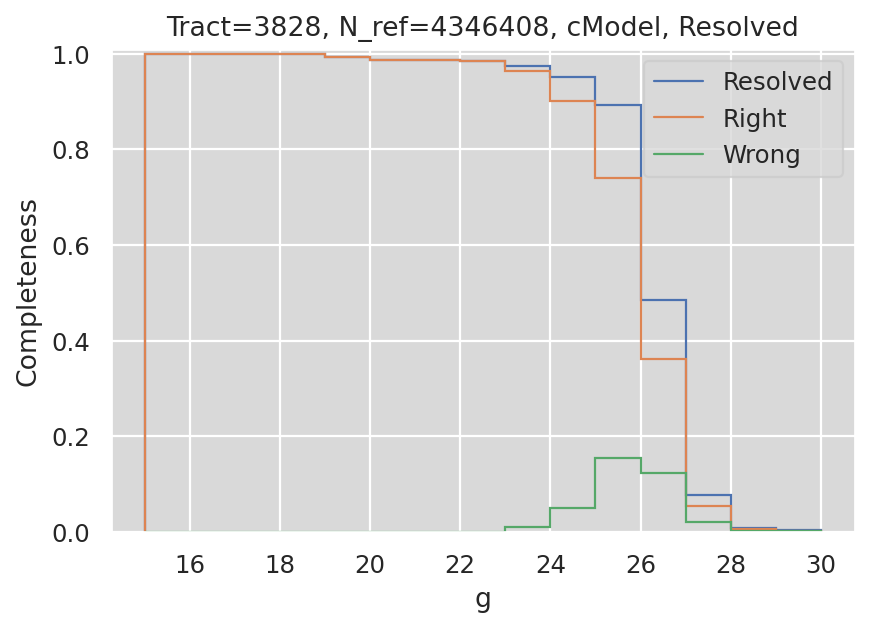

g band, Resolved, Measured


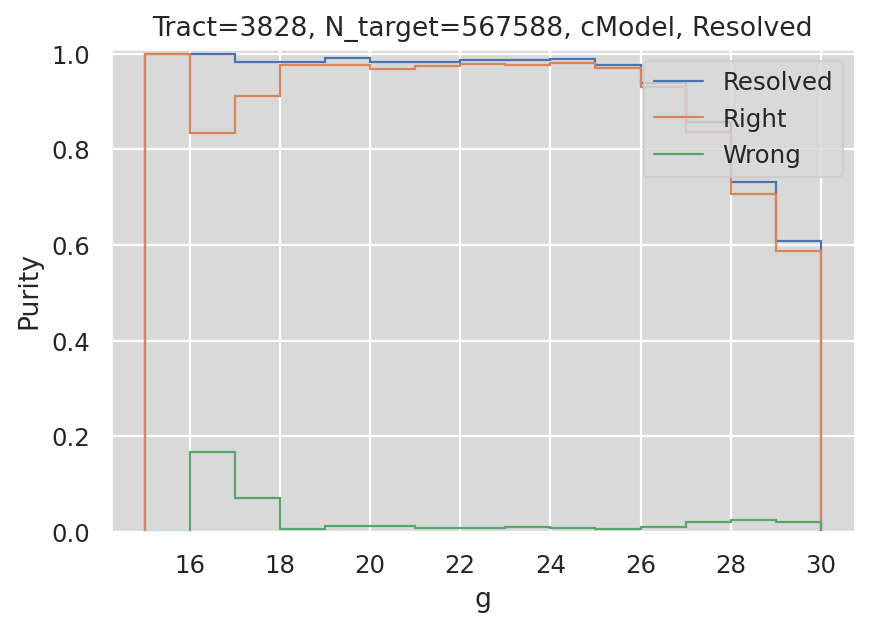

g band, Unresolved
g band, Unresolved, Reference


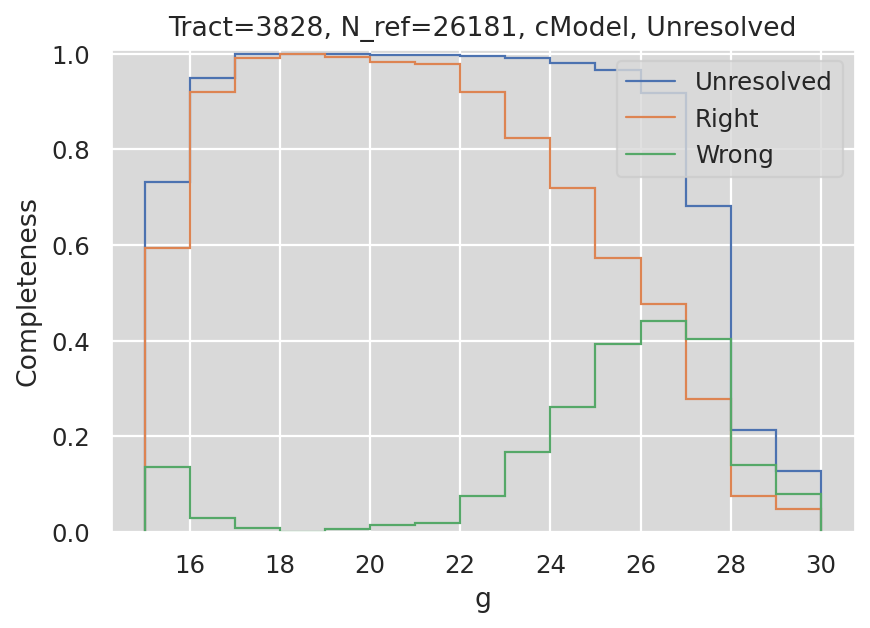

g band, Unresolved, Measured


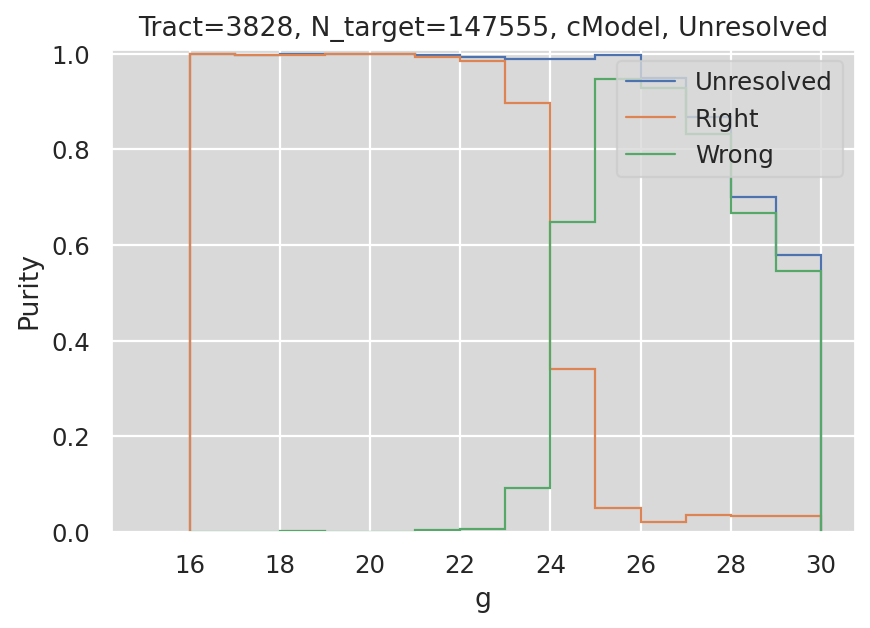

r band
r band, All
r band, All, Reference


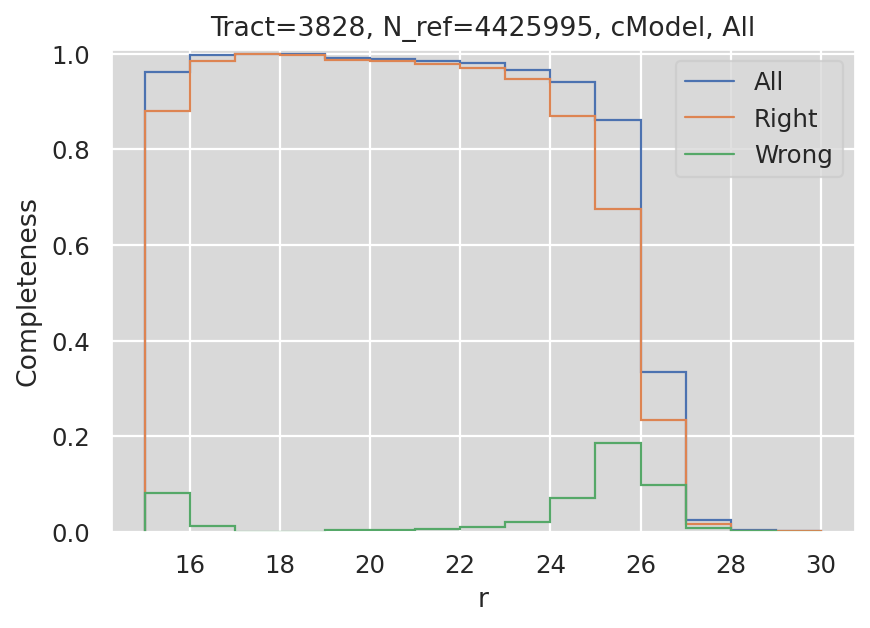

r band, All, Measured


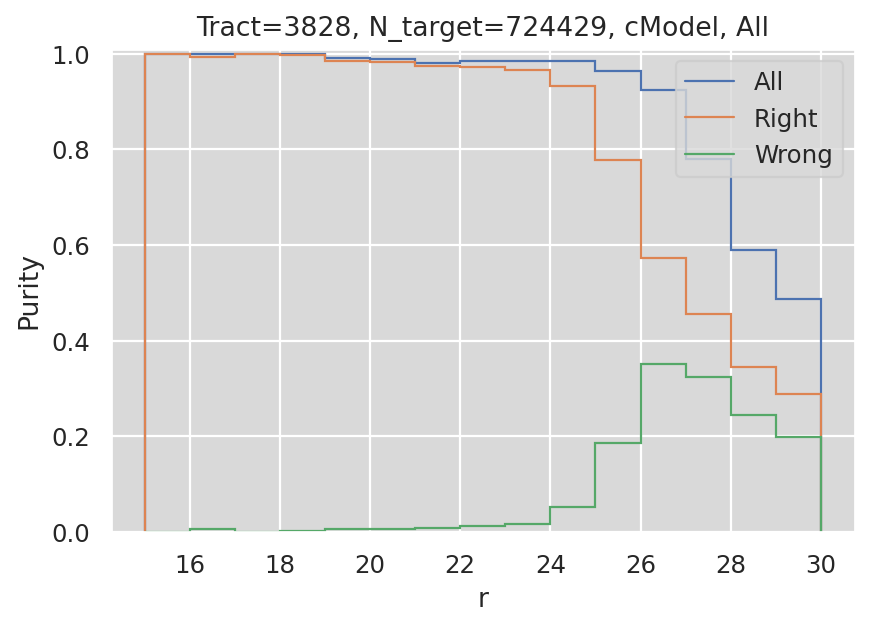

r band, Resolved
r band, Resolved, Reference


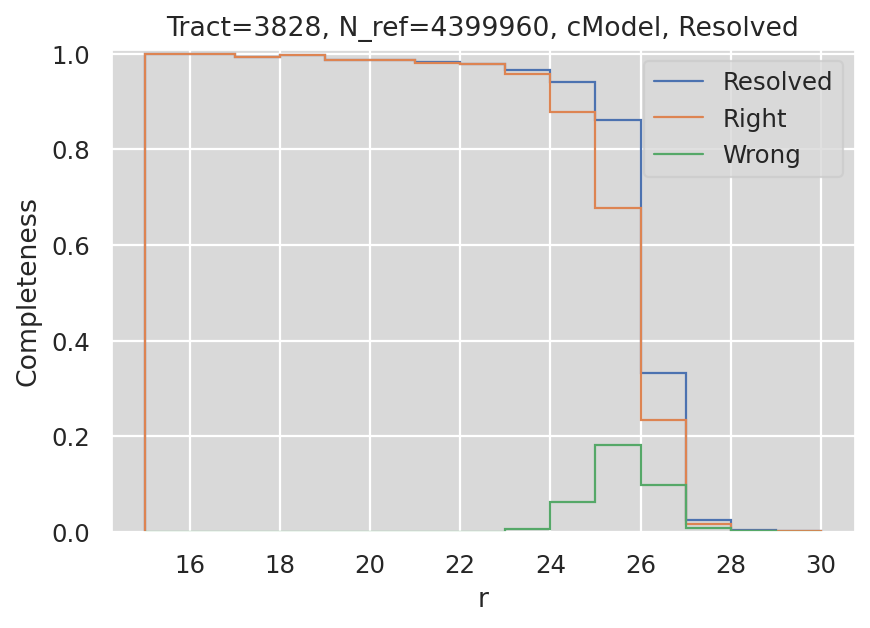

r band, Resolved, Measured


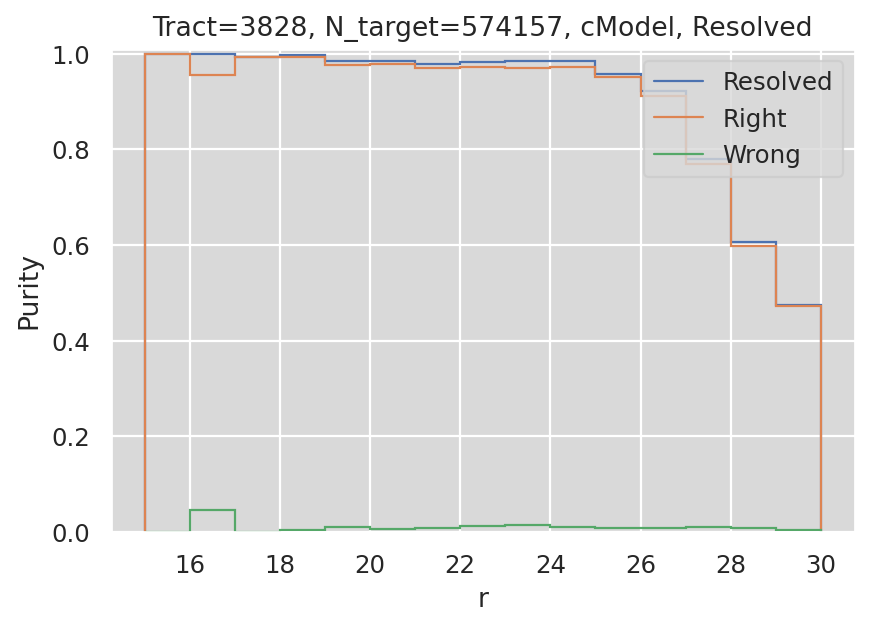

r band, Unresolved
r band, Unresolved, Reference


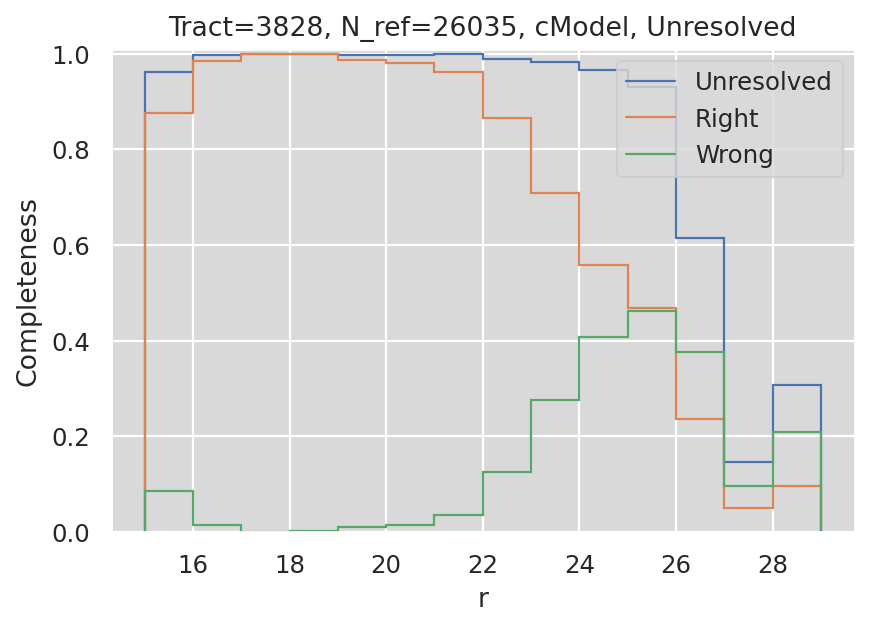

r band, Unresolved, Measured


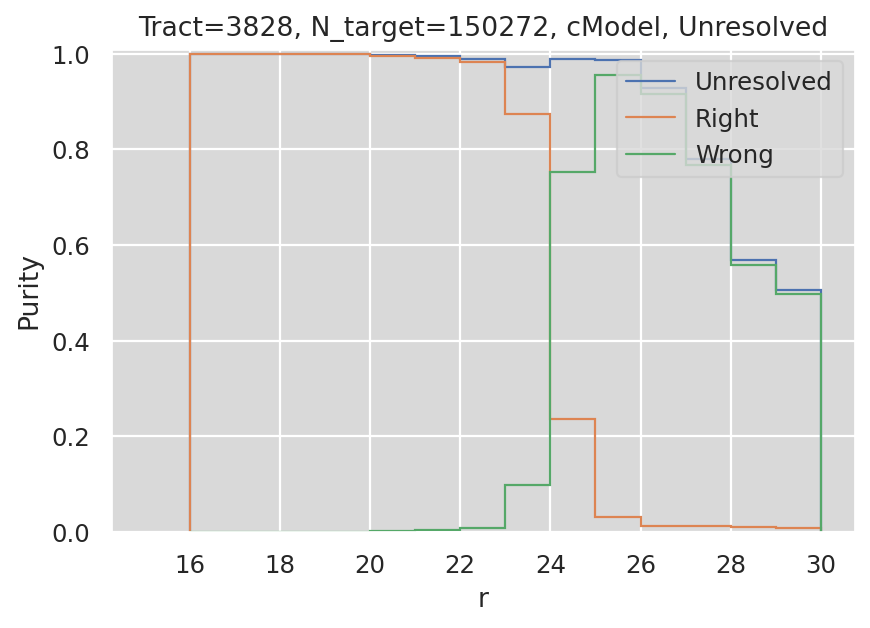

i band
i band, All
i band, All, Reference


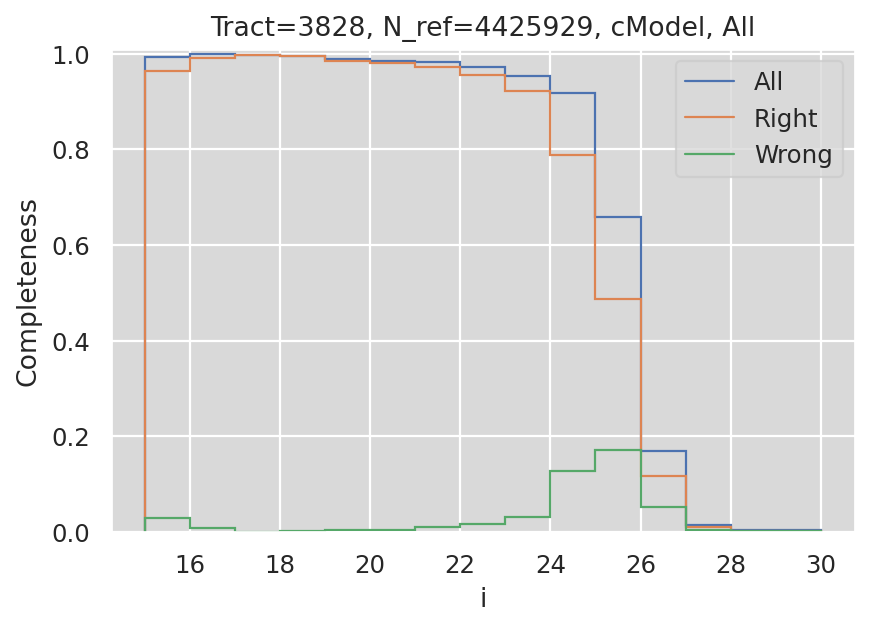

i band, All, Measured


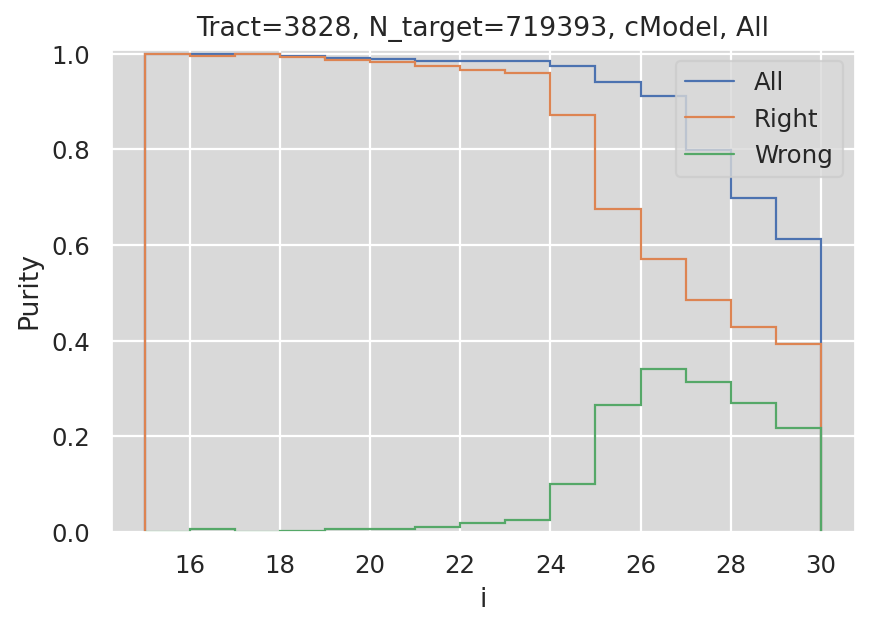

i band, Resolved
i band, Resolved, Reference


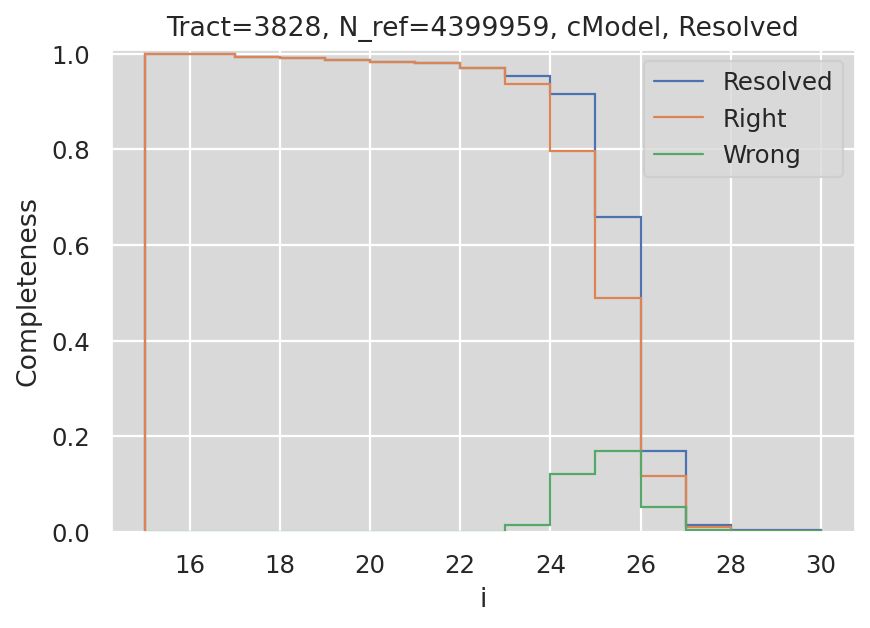

i band, Resolved, Measured


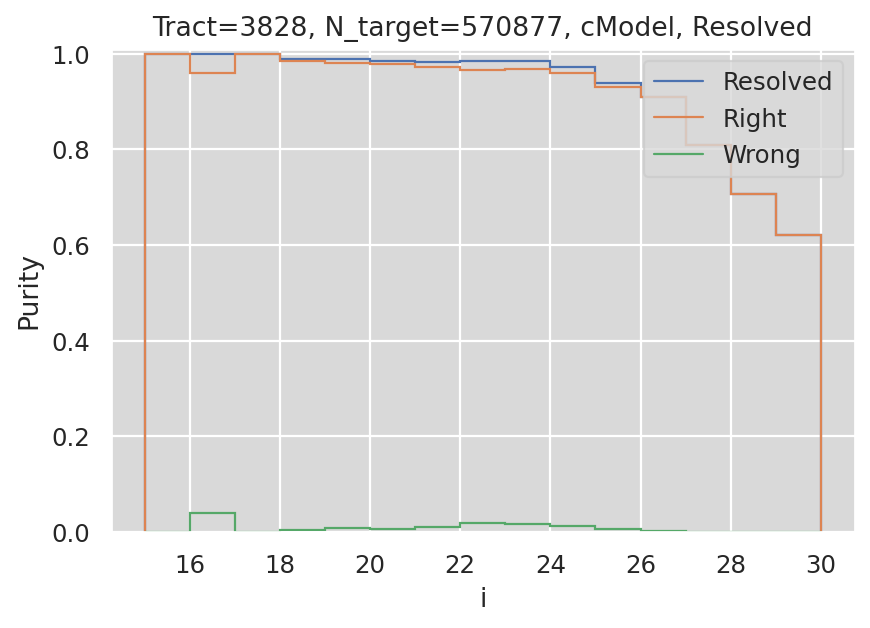

i band, Unresolved
i band, Unresolved, Reference


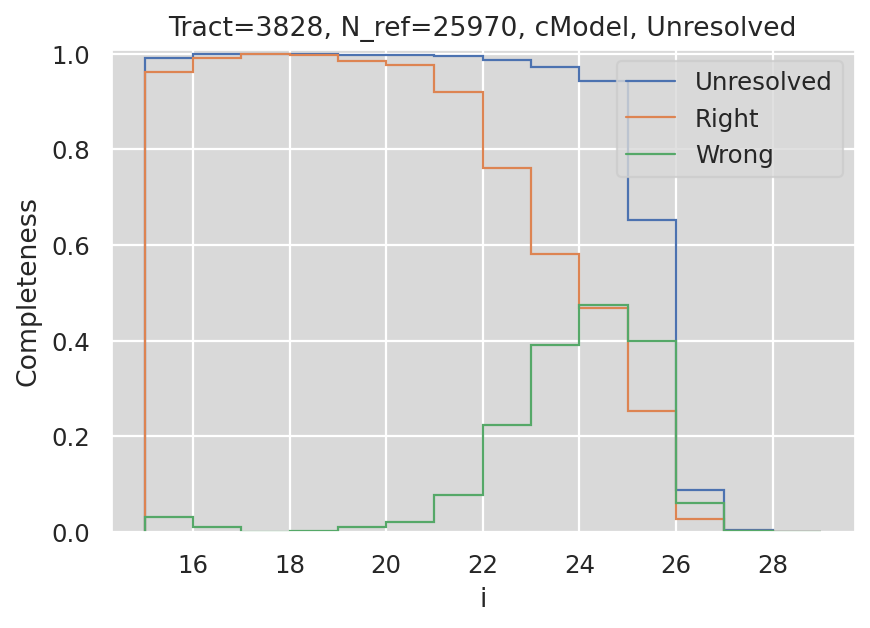

i band, Unresolved, Measured


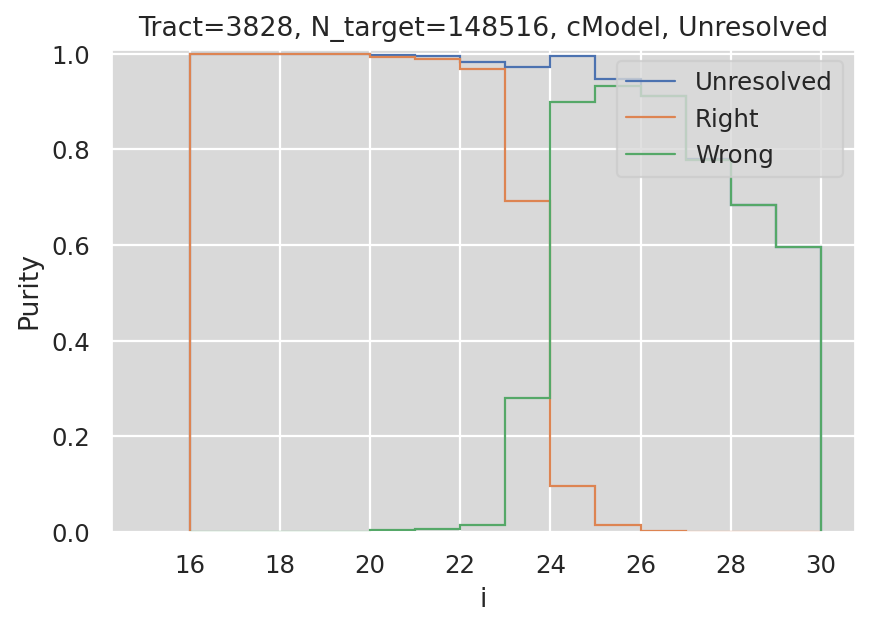

z band
z band, All
z band, All, Reference


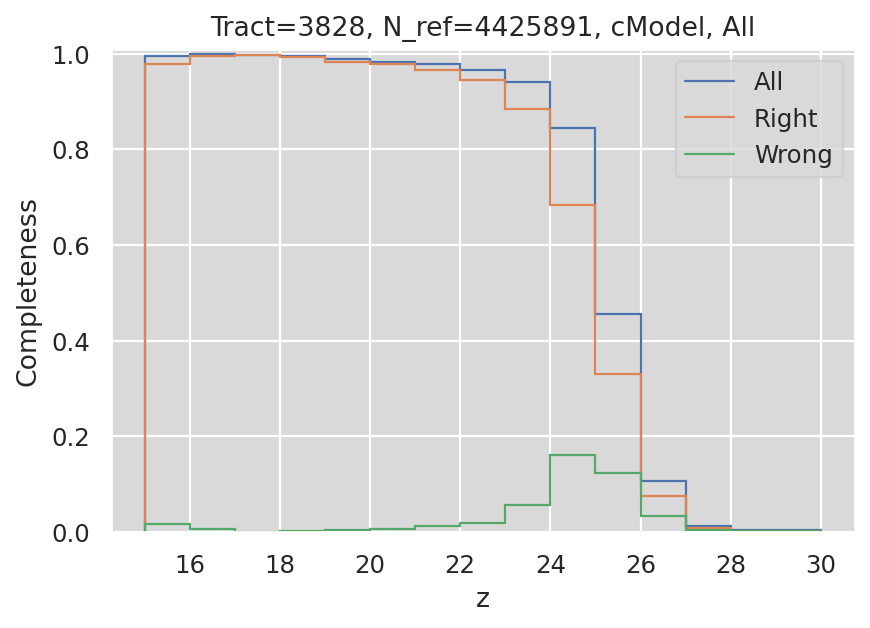

z band, All, Measured


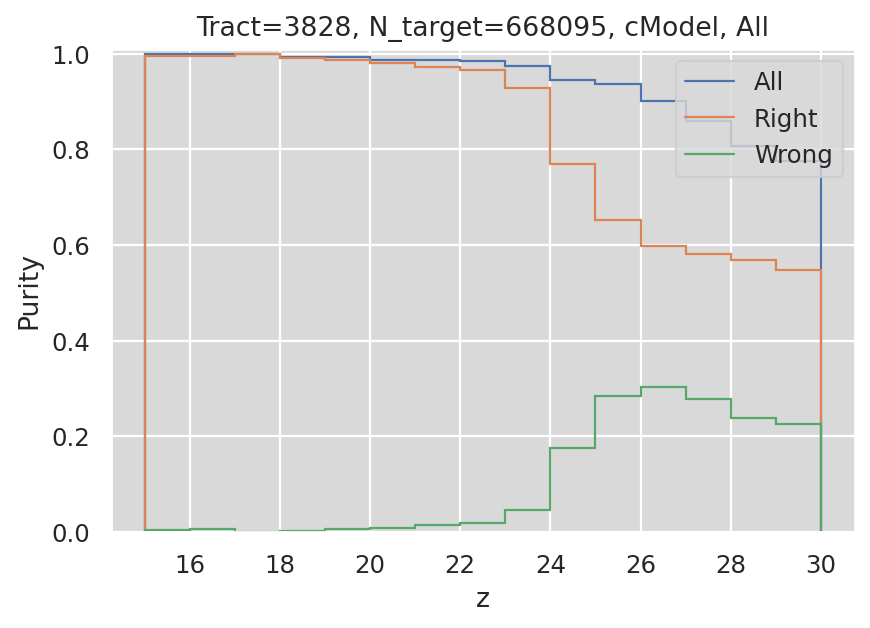

z band, Resolved
z band, Resolved, Reference


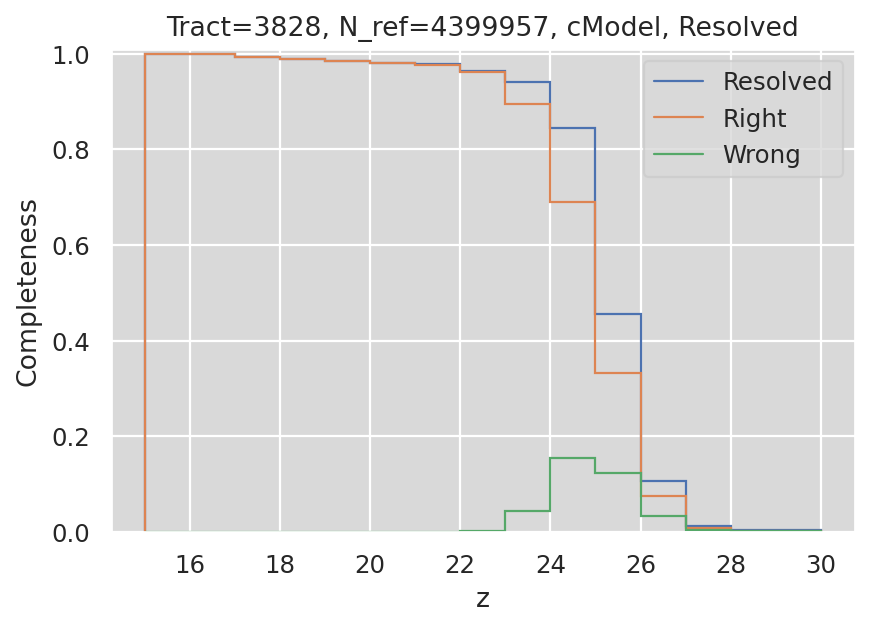

z band, Resolved, Measured


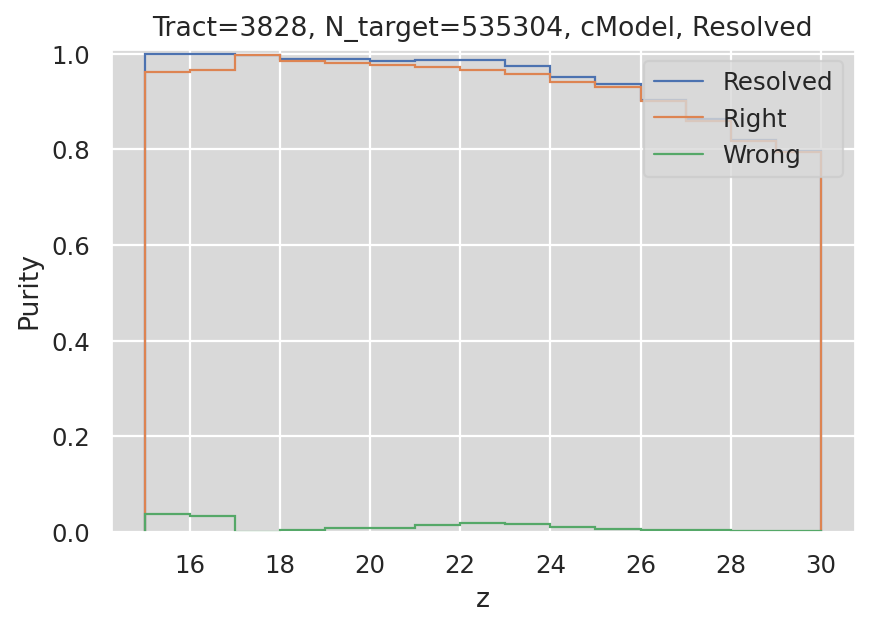

z band, Unresolved
z band, Unresolved, Reference


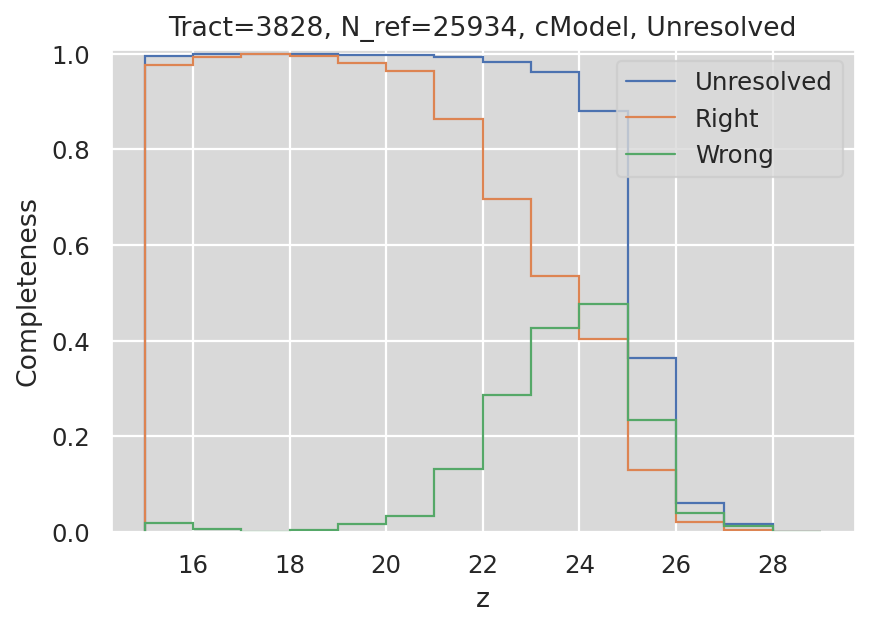

z band, Unresolved, Measured


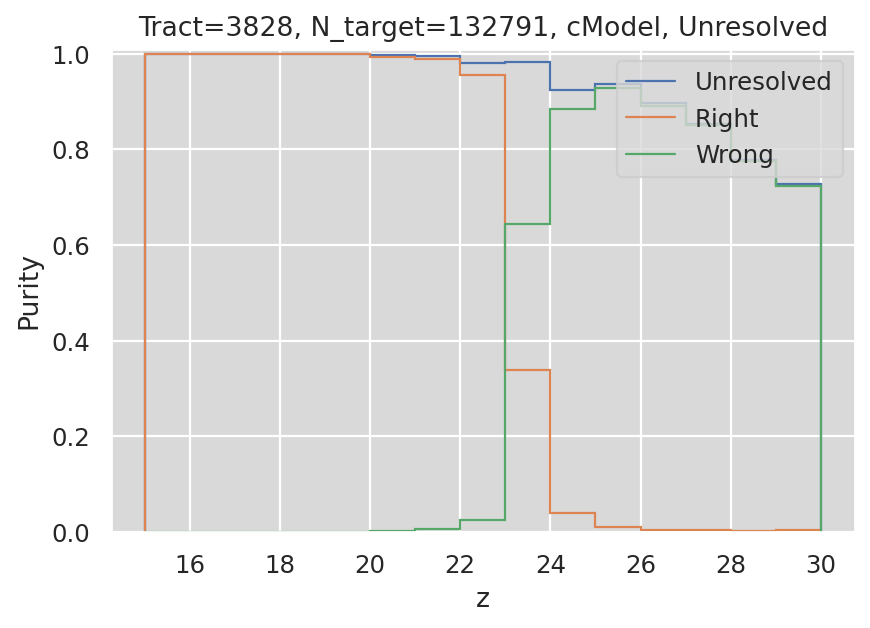

y band
y band, All
y band, All, Reference


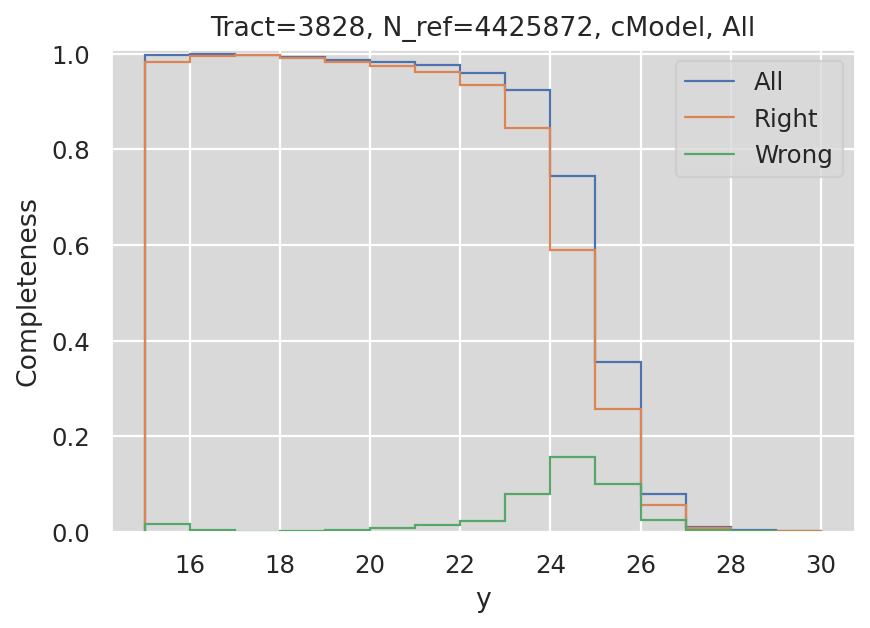

y band, All, Measured


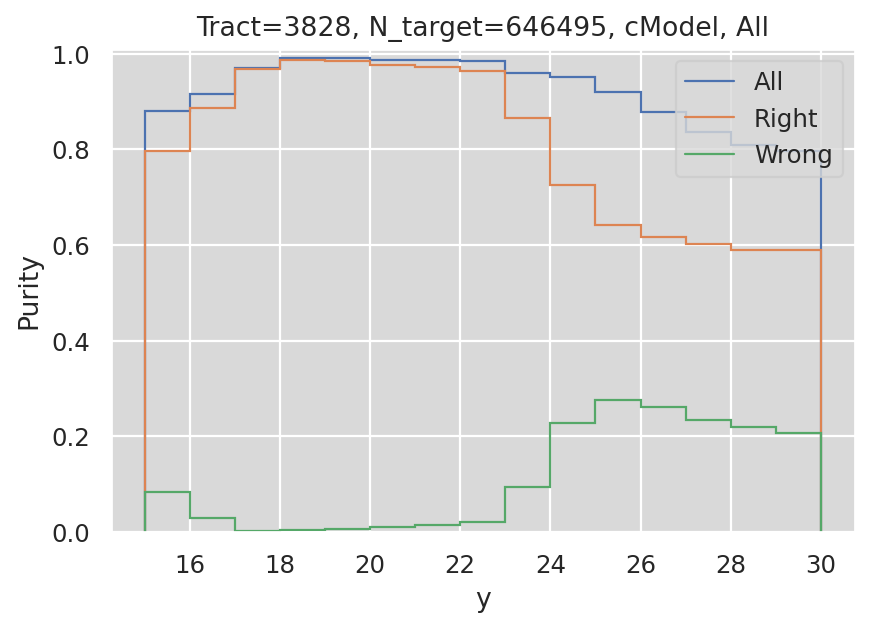

y band, Resolved
y band, Resolved, Reference


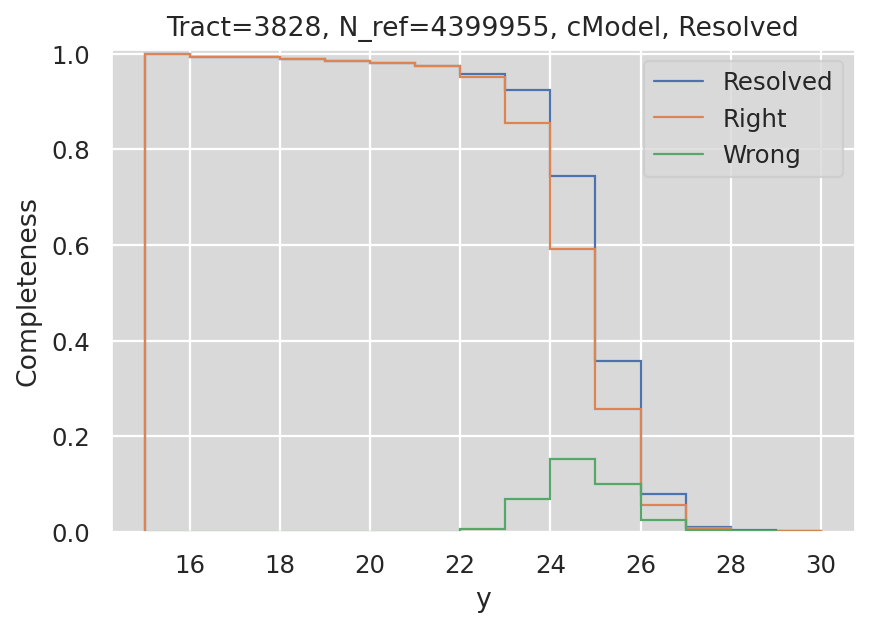

y band, Resolved, Measured


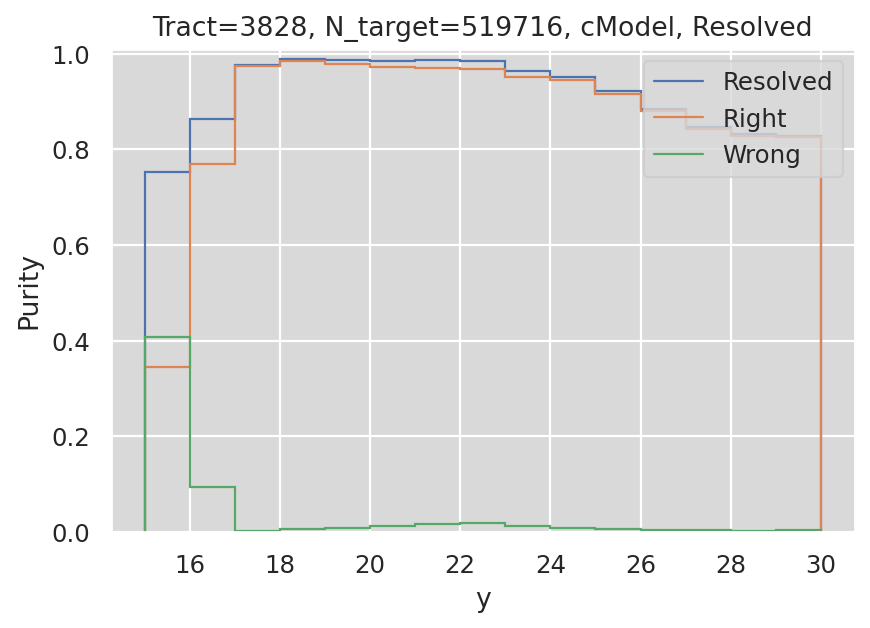

y band, Unresolved
y band, Unresolved, Reference


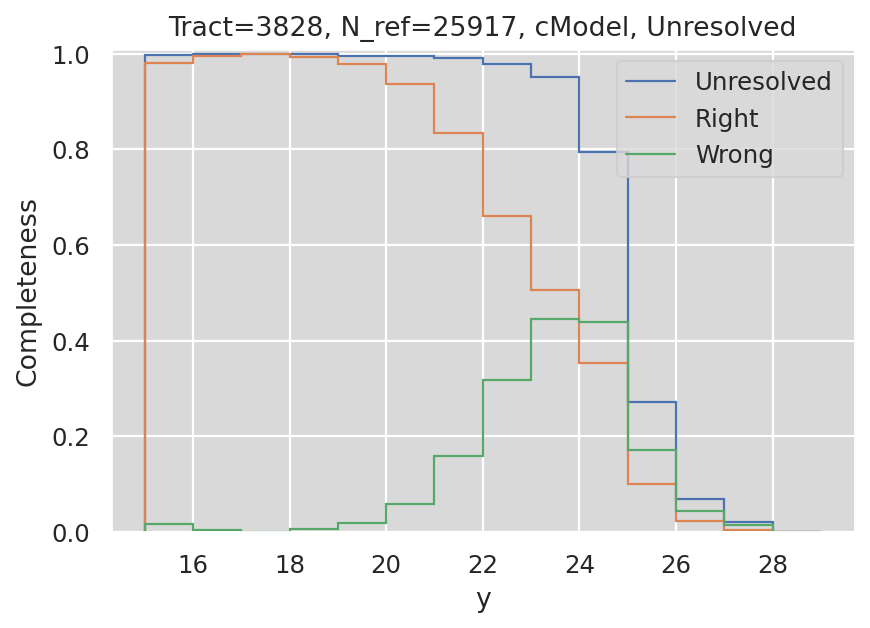

y band, Unresolved, Measured


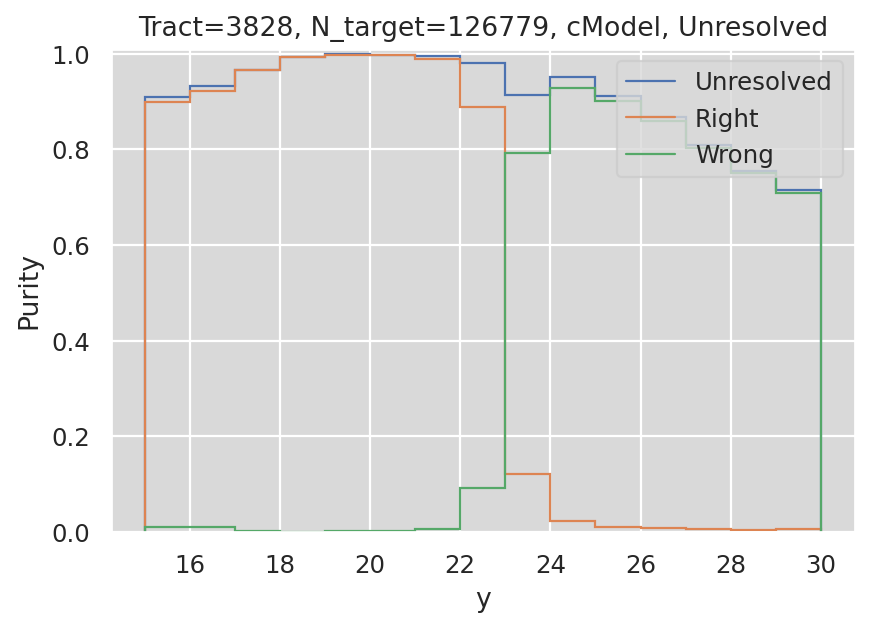

u band
u band, All
u band, All, Reference


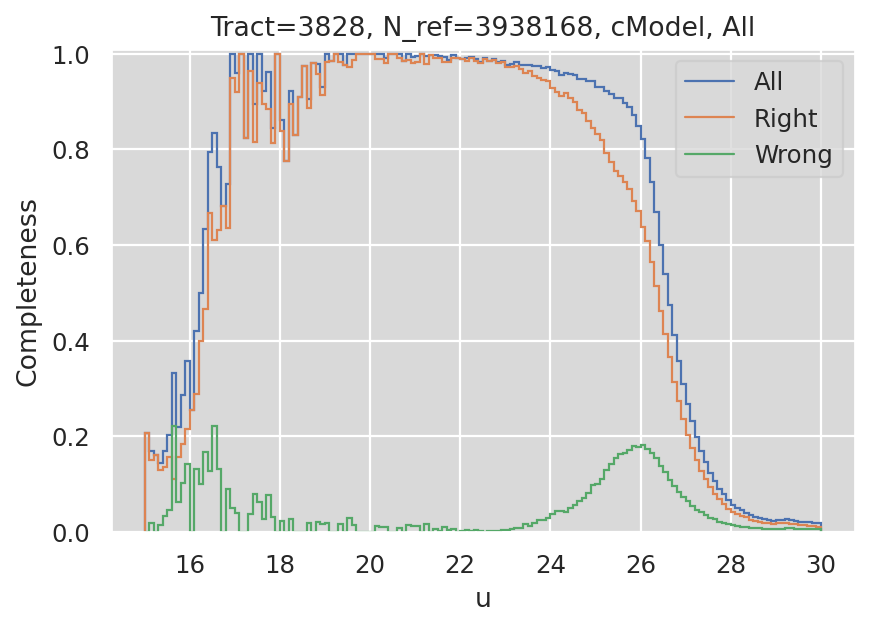

u band, All, Measured


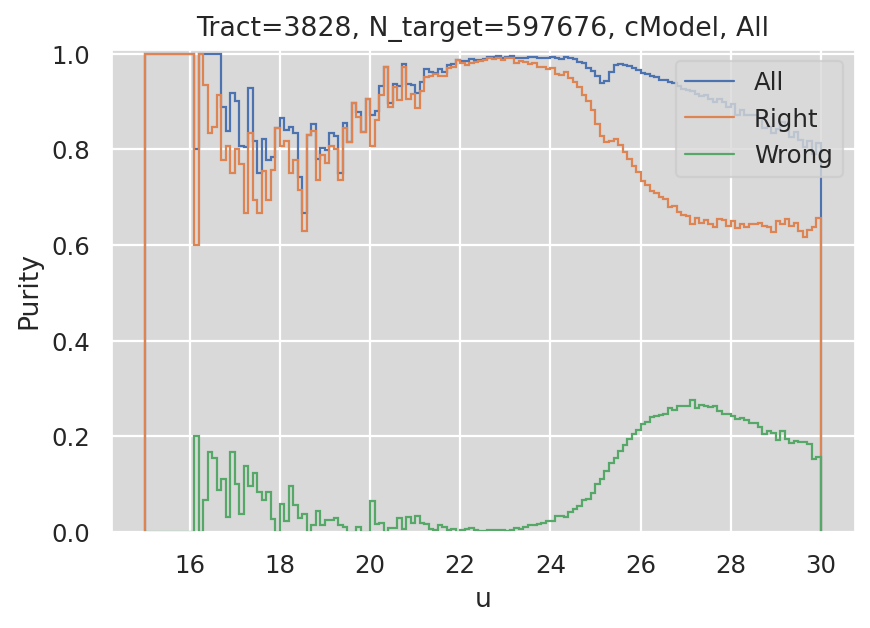

u band, Resolved
u band, Resolved, Reference


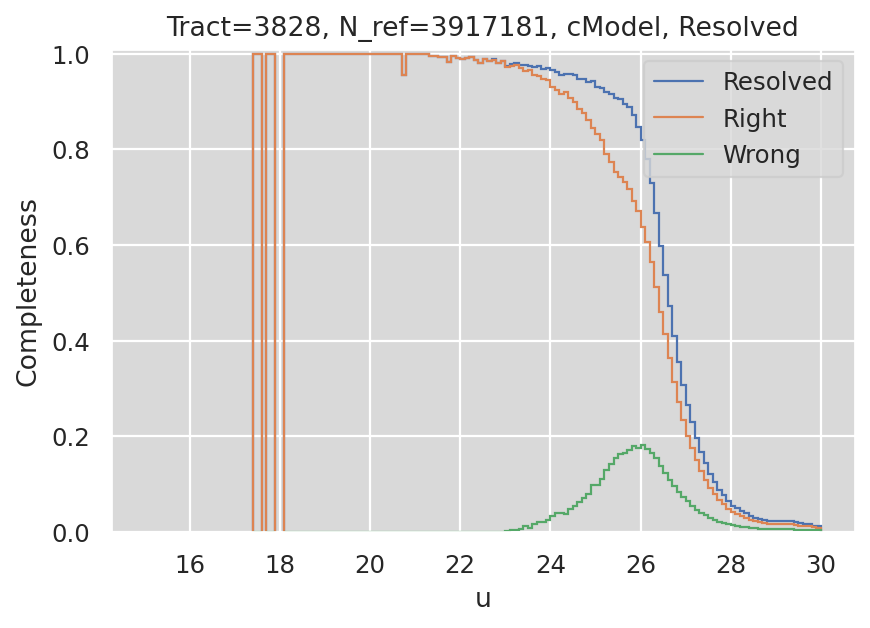

u band, Resolved, Measured


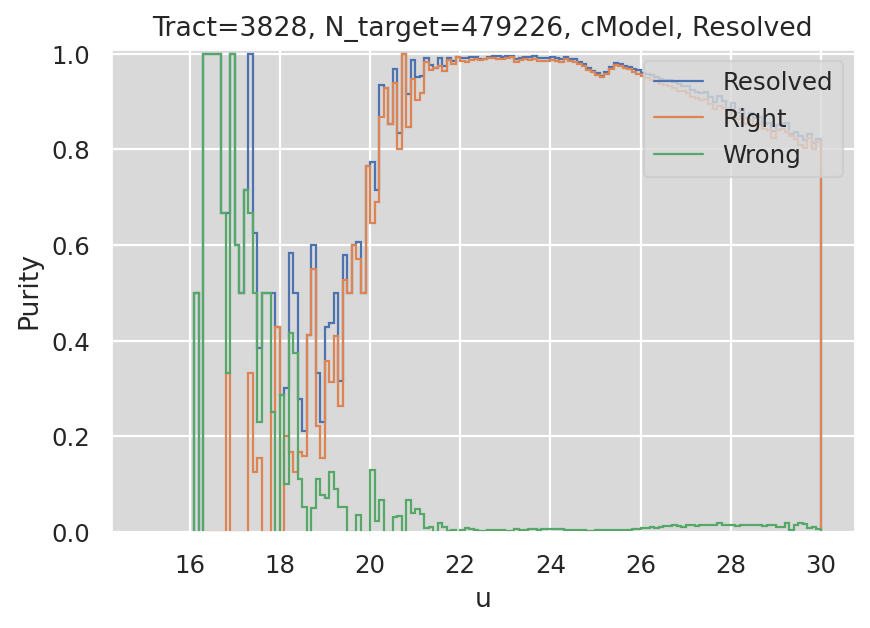

u band, Unresolved
u band, Unresolved, Reference


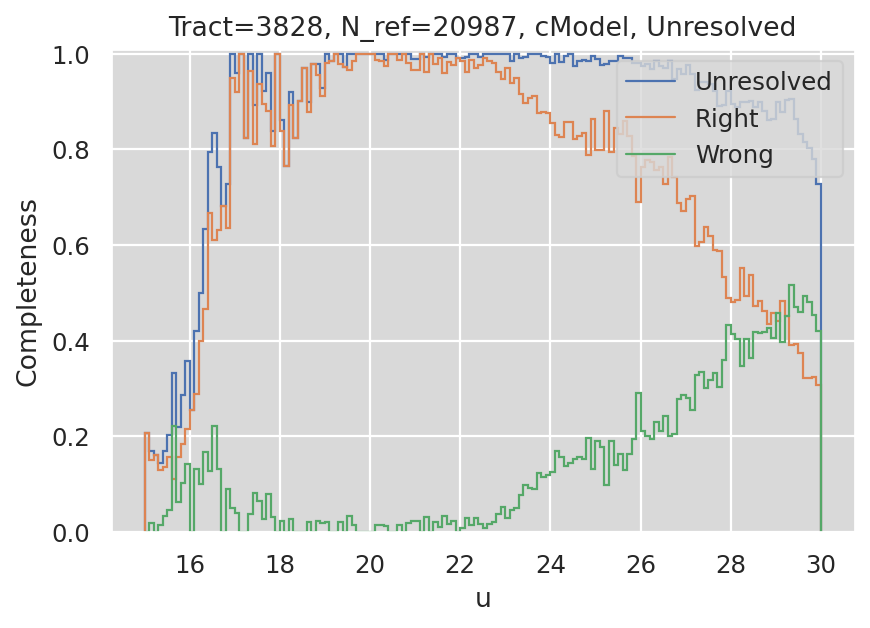

u band, Unresolved, Measured


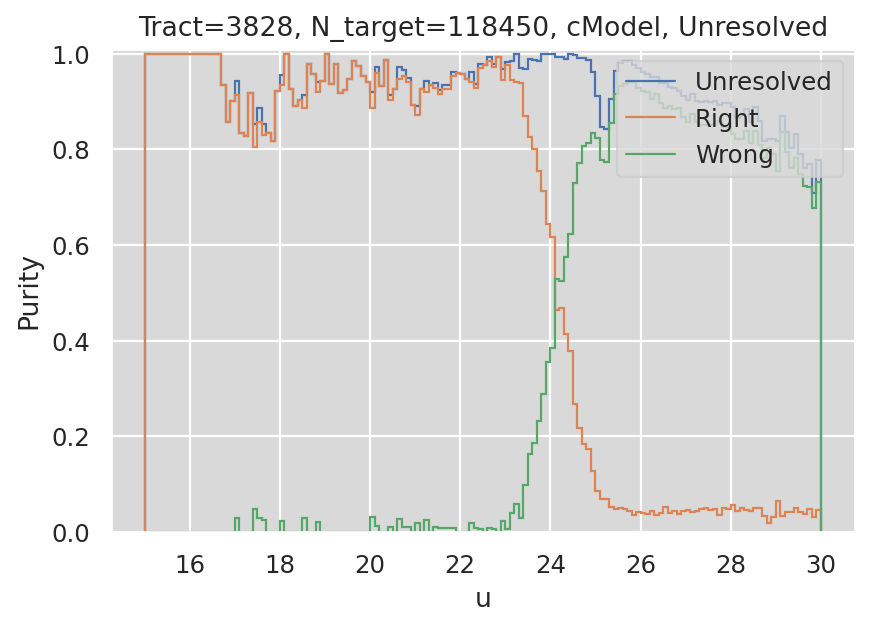

g band
g band, All
g band, All, Reference


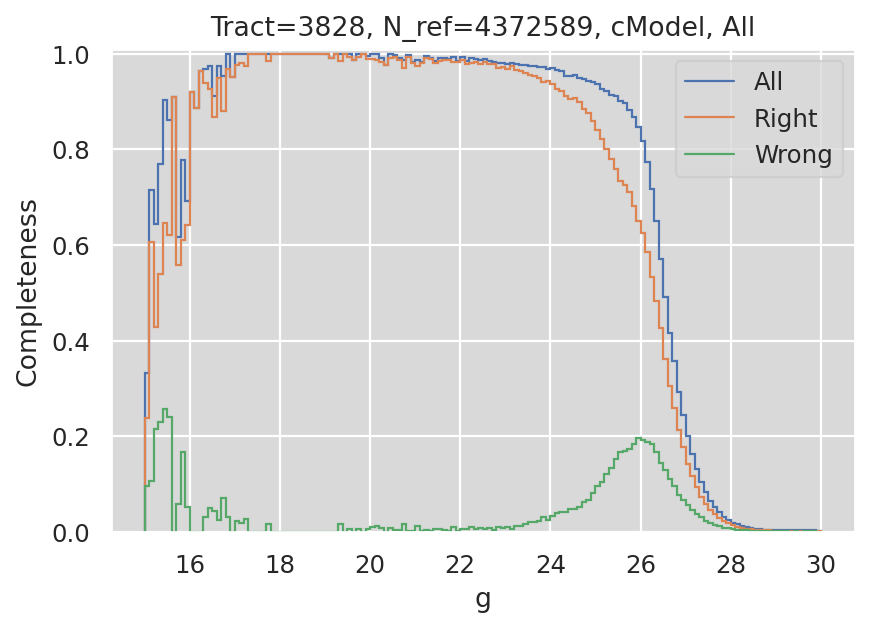

g band, All, Measured


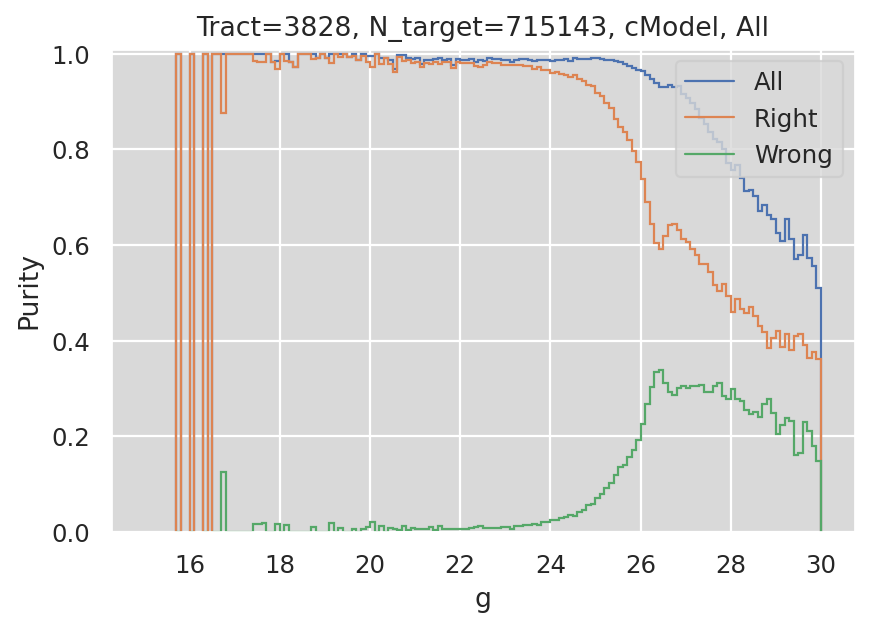

g band, Resolved
g band, Resolved, Reference


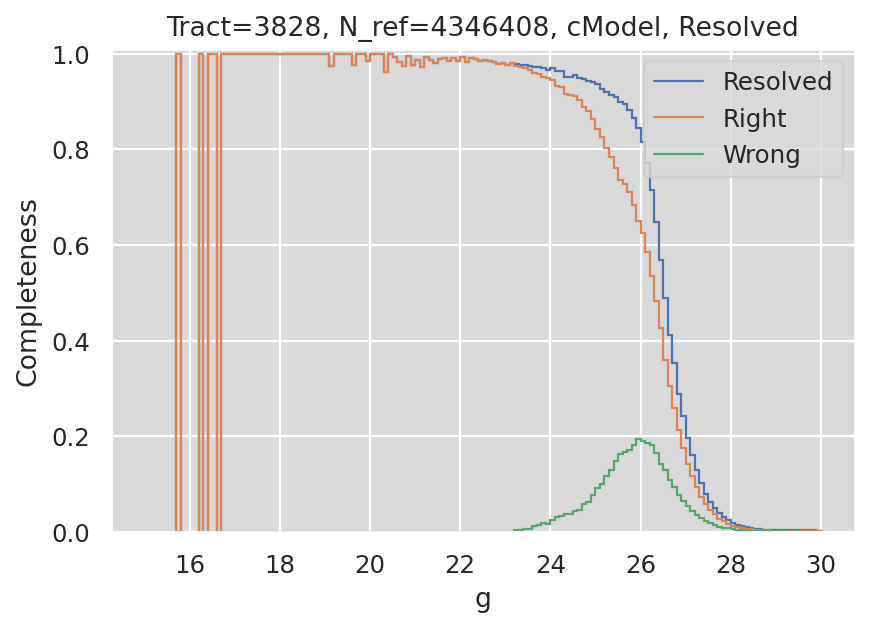

g band, Resolved, Measured


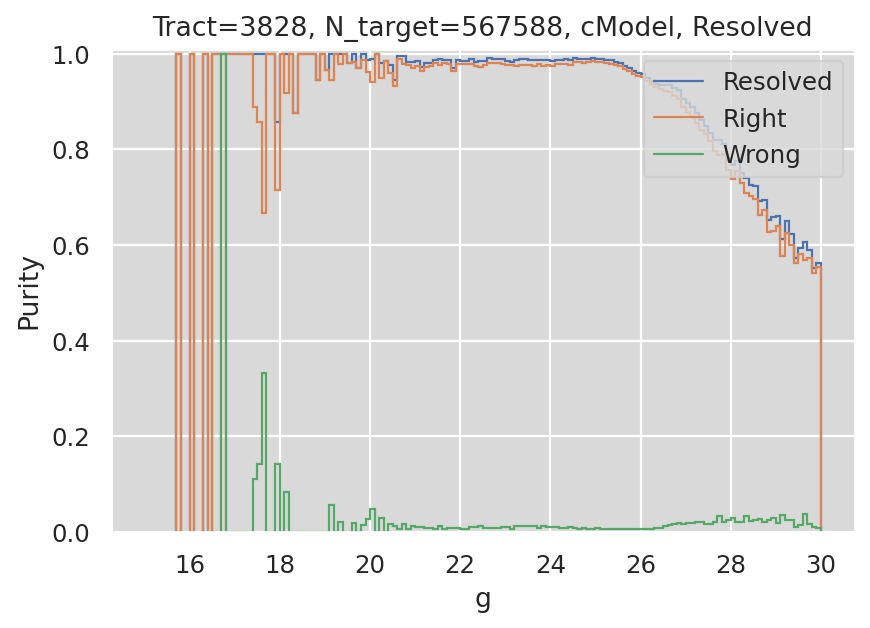

g band, Unresolved
g band, Unresolved, Reference


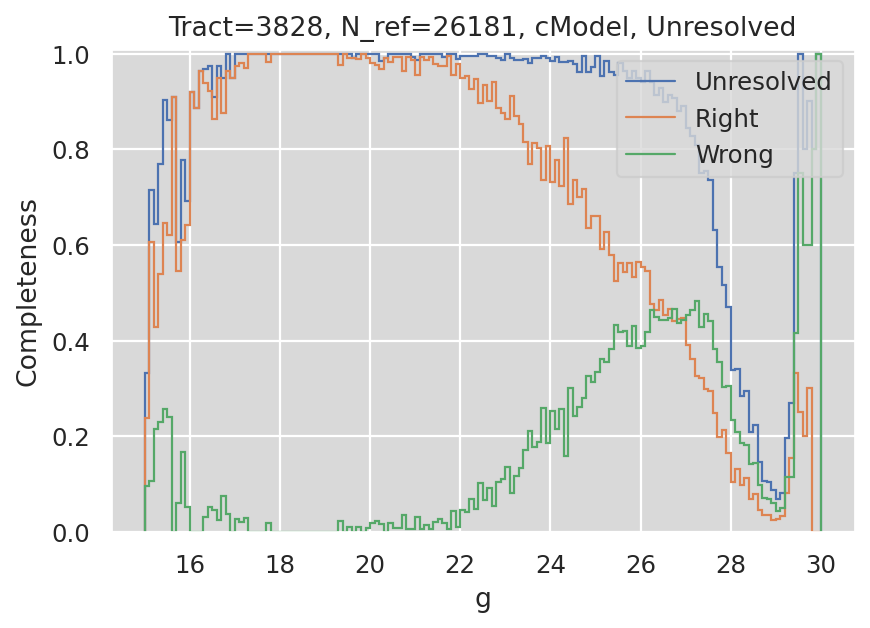

g band, Unresolved, Measured


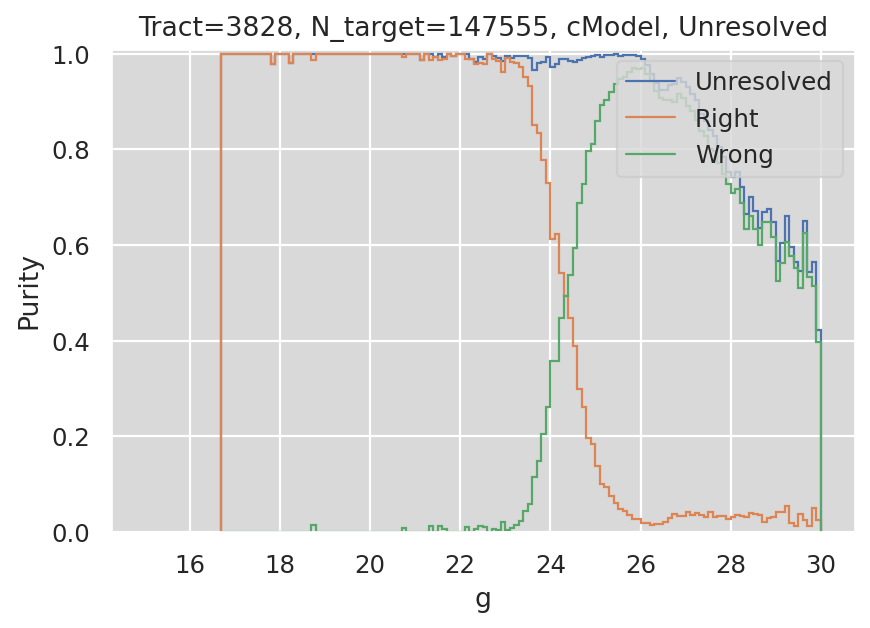

r band
r band, All
r band, All, Reference


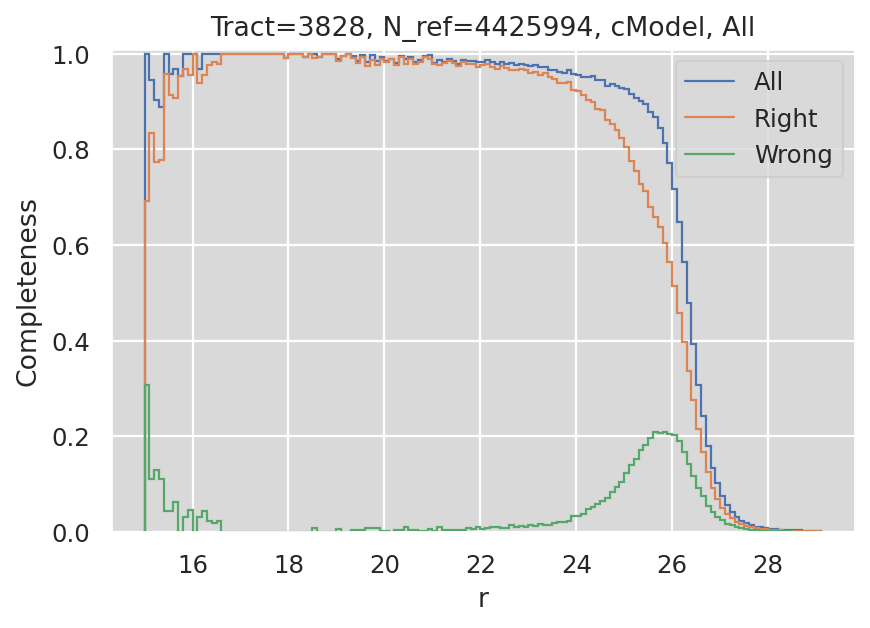

r band, All, Measured


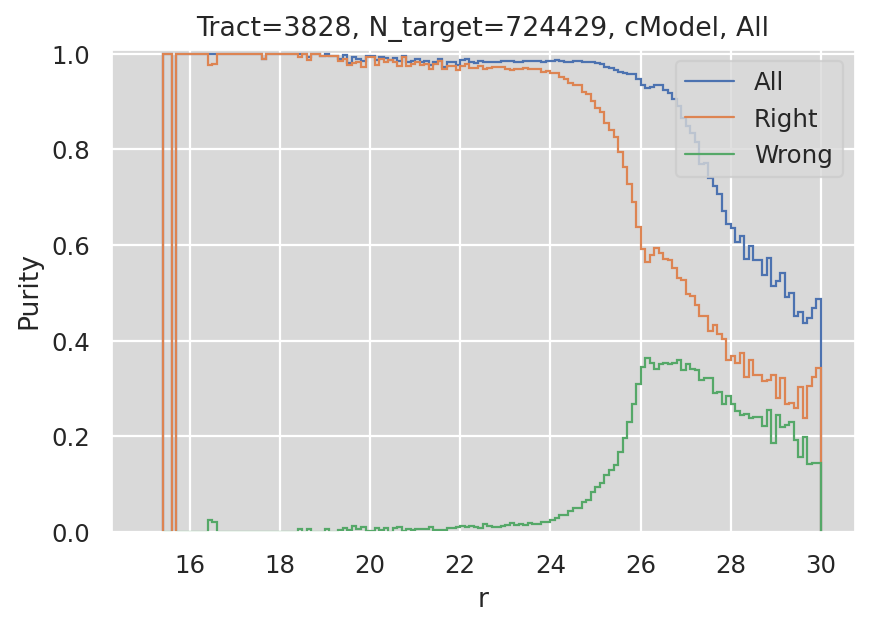

r band, Resolved
r band, Resolved, Reference


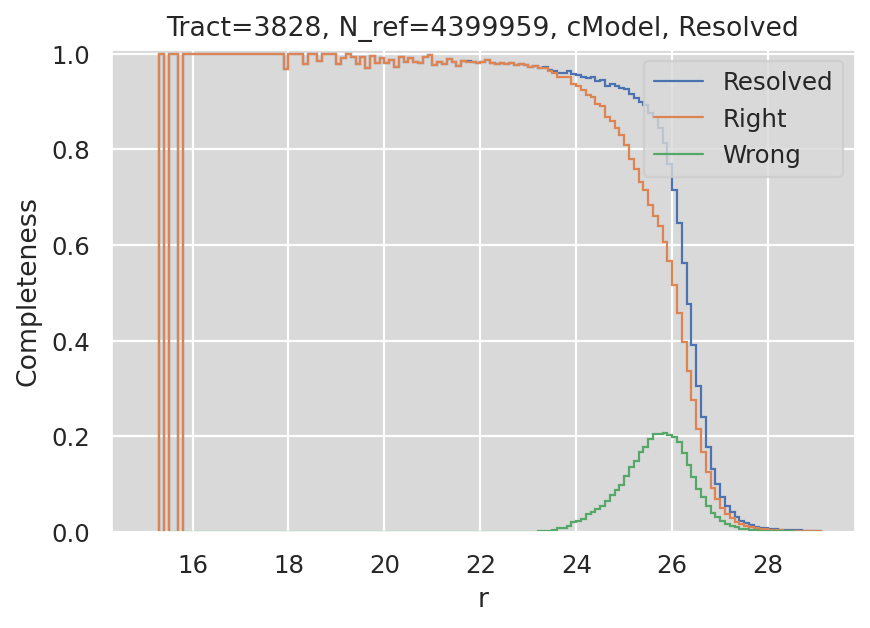

r band, Resolved, Measured


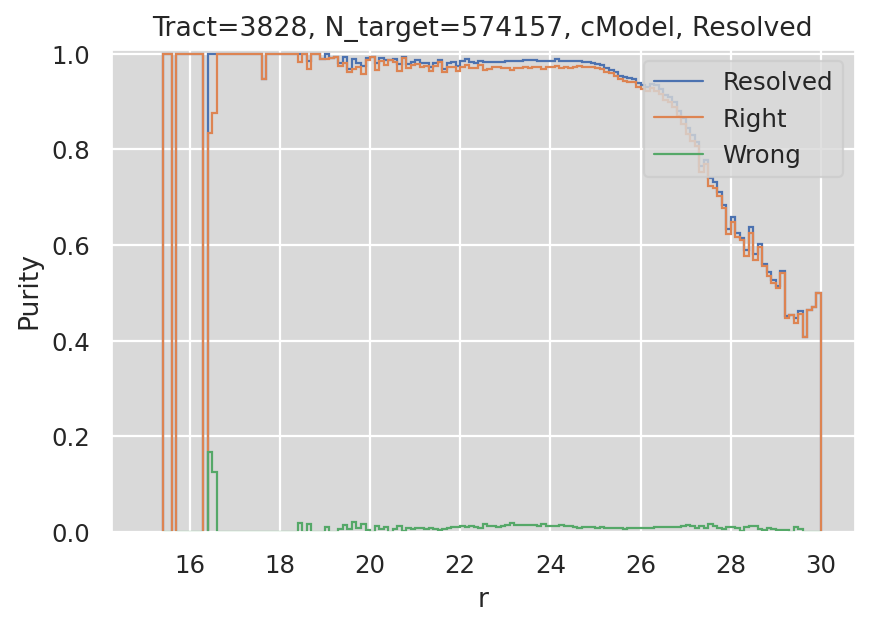

r band, Unresolved
r band, Unresolved, Reference


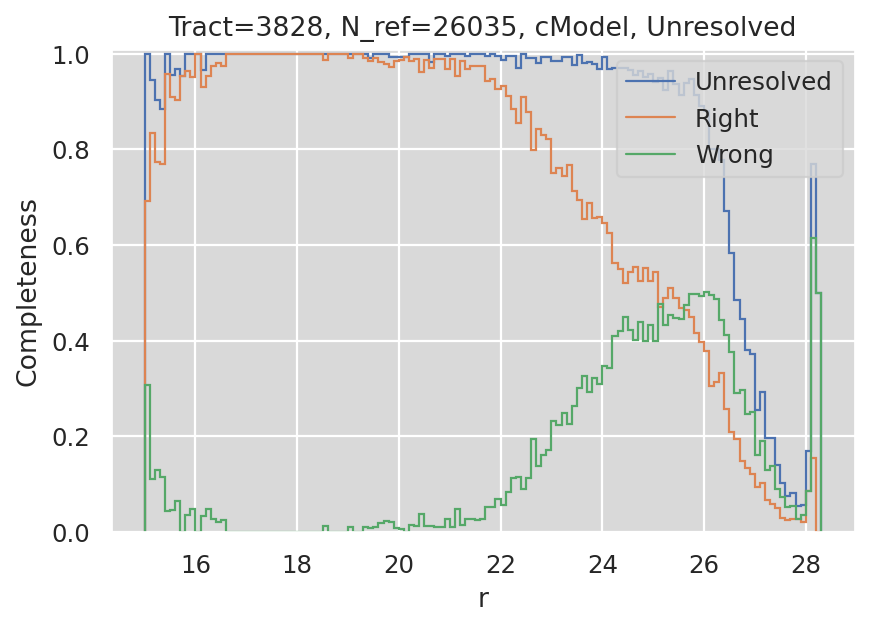

r band, Unresolved, Measured


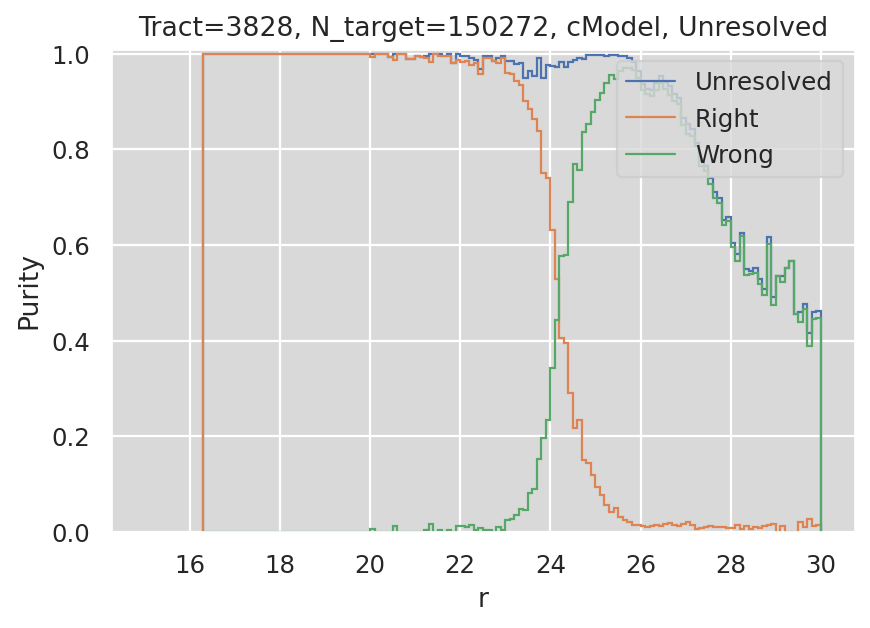

i band
i band, All
i band, All, Reference


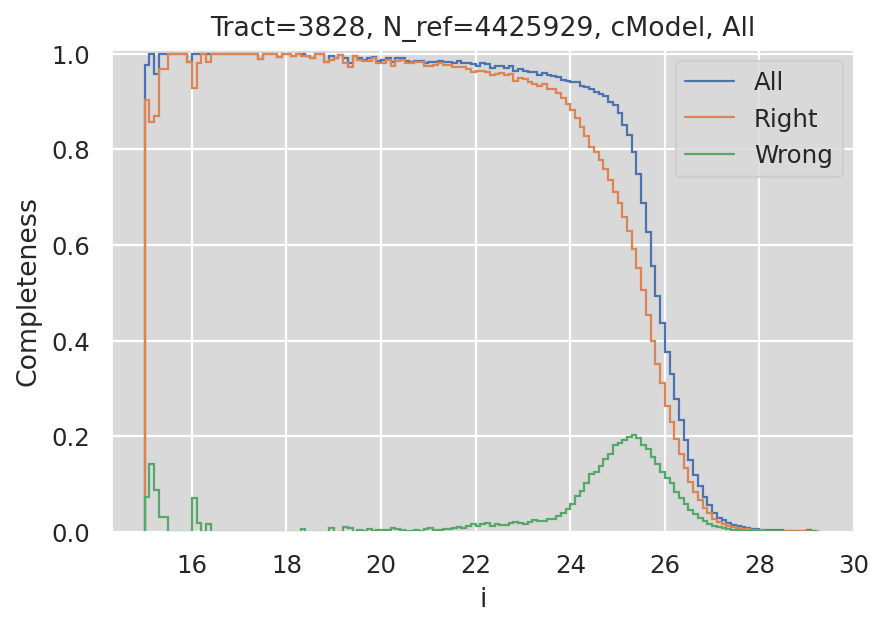

i band, All, Measured


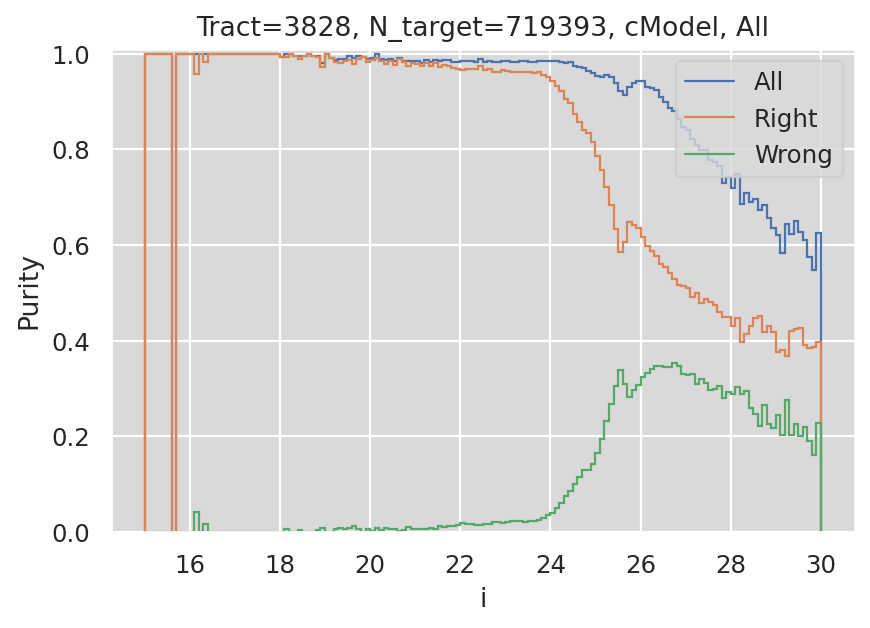

i band, Resolved
i band, Resolved, Reference


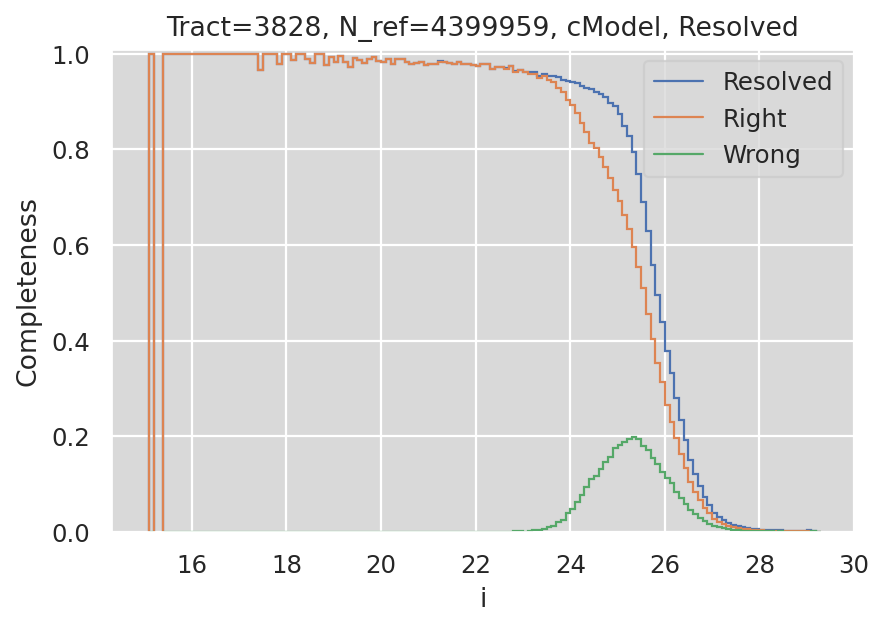

i band, Resolved, Measured


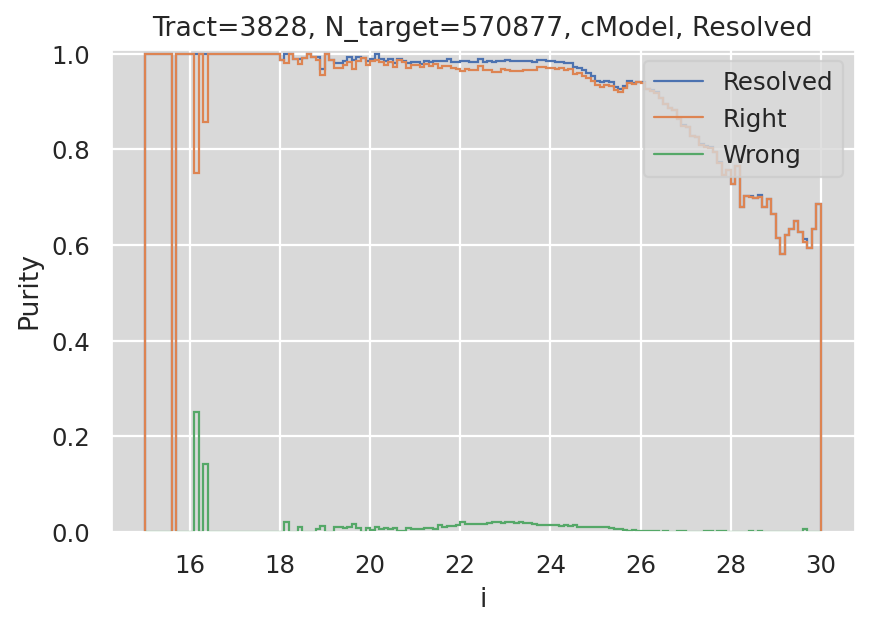

i band, Unresolved
i band, Unresolved, Reference


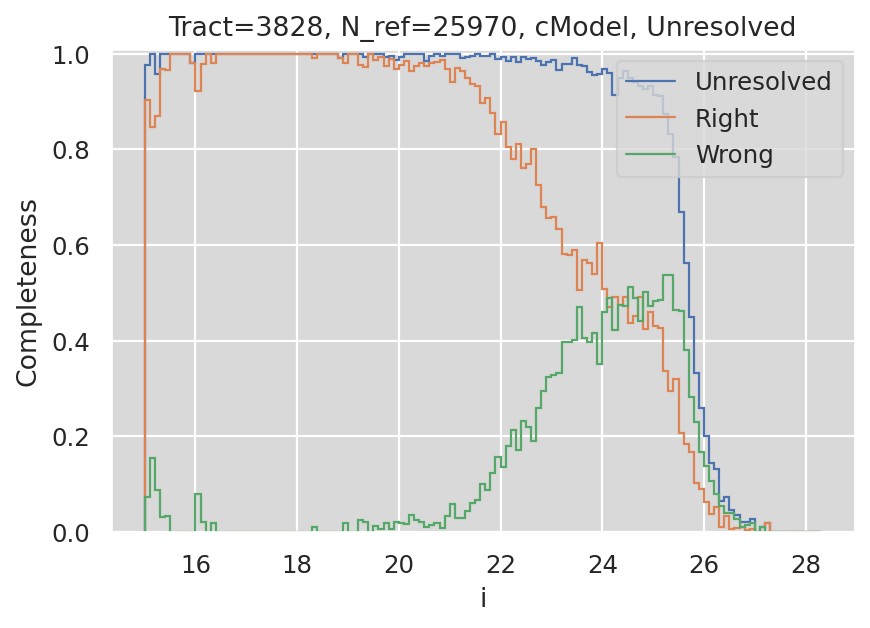

i band, Unresolved, Measured


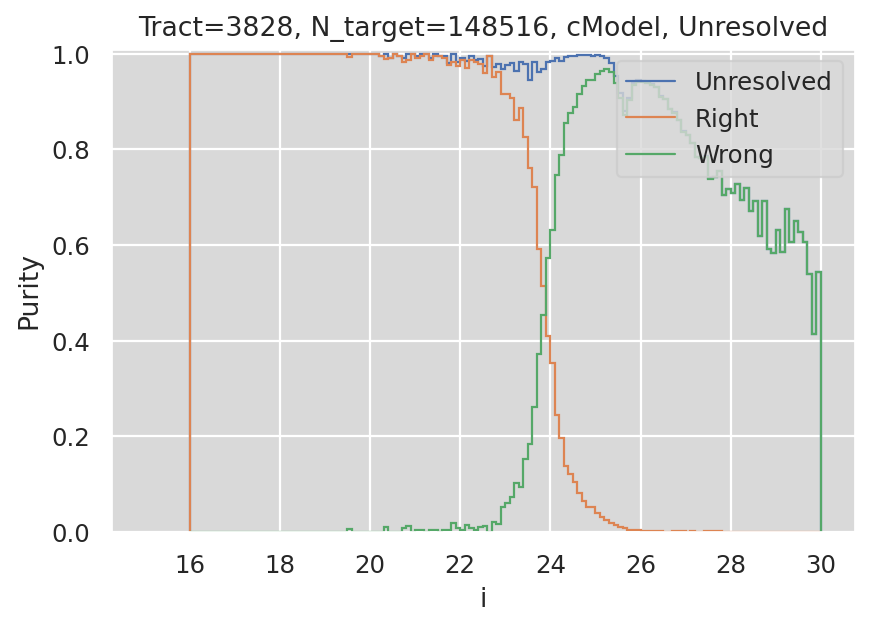

z band
z band, All
z band, All, Reference


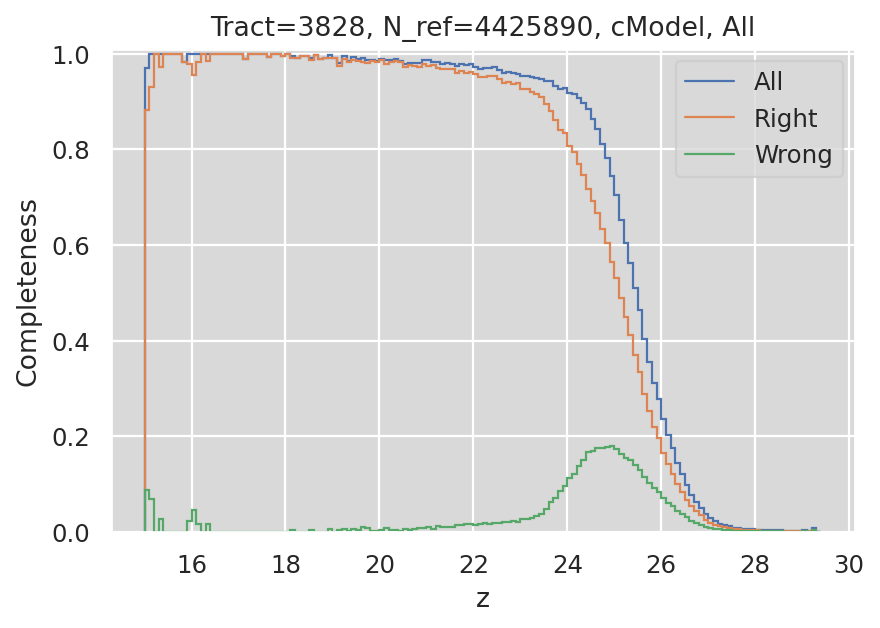

z band, All, Measured


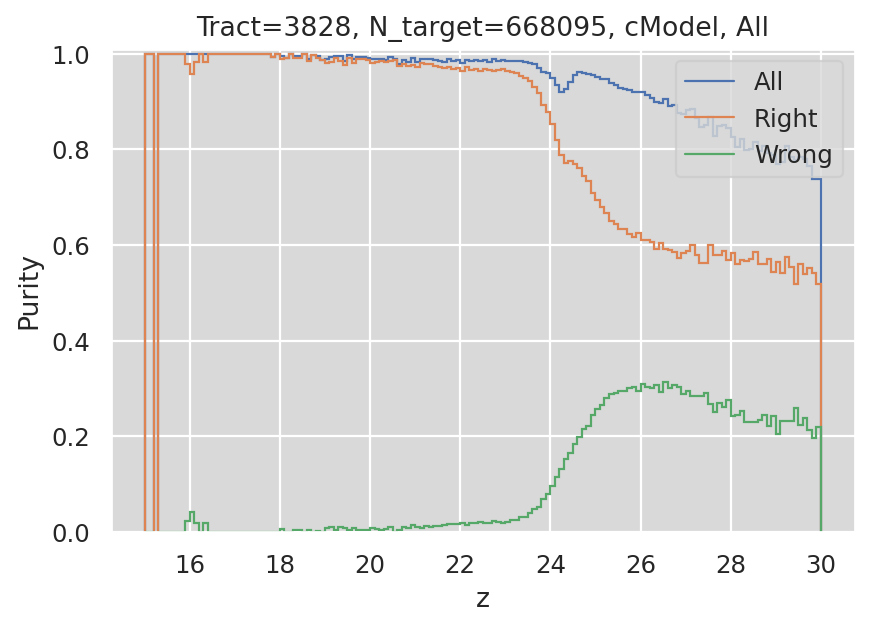

z band, Resolved
z band, Resolved, Reference


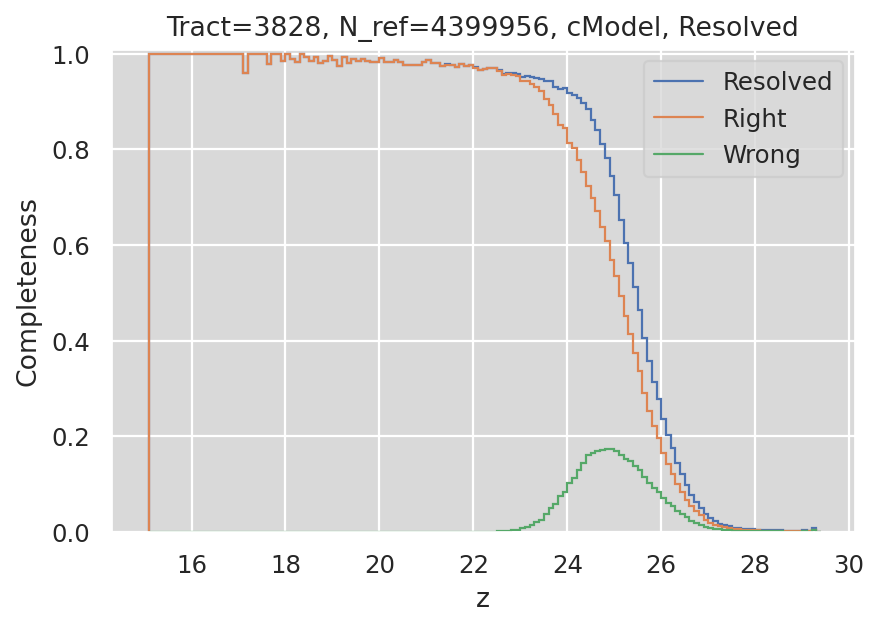

z band, Resolved, Measured


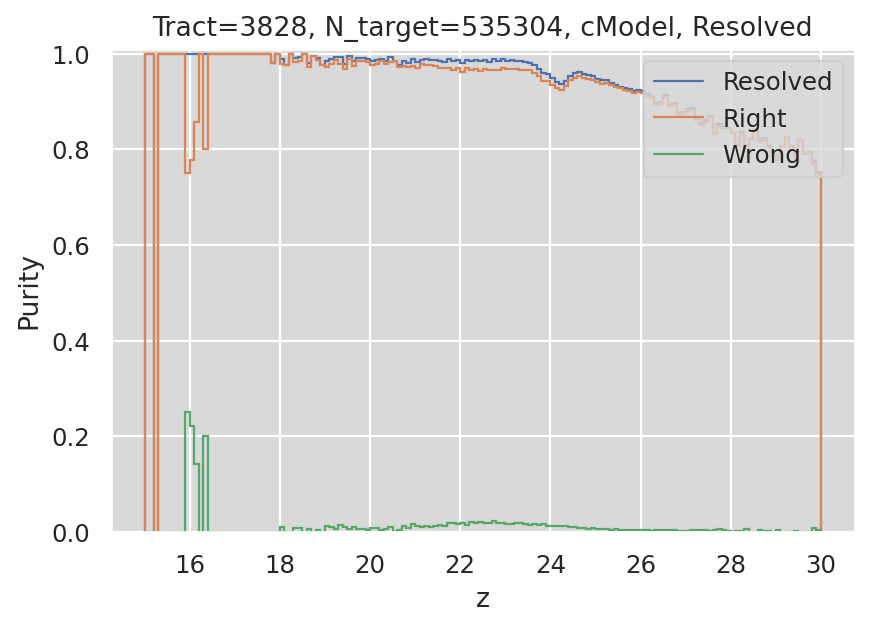

z band, Unresolved
z band, Unresolved, Reference


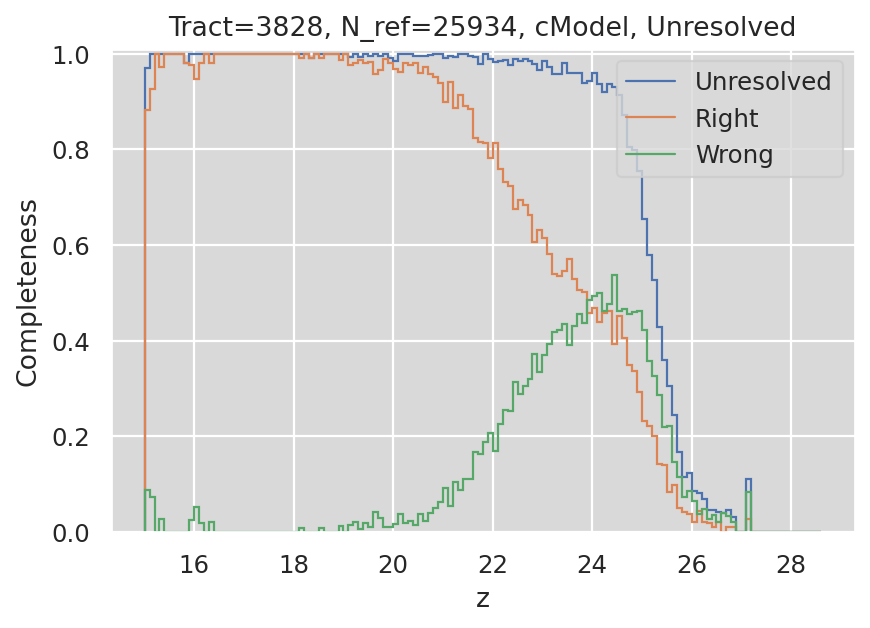

z band, Unresolved, Measured


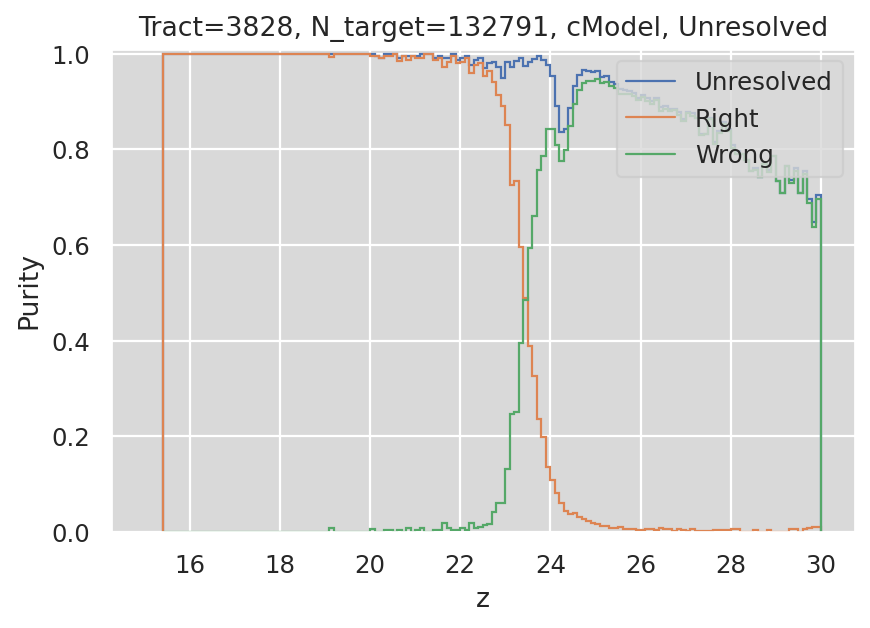

y band
y band, All
y band, All, Reference


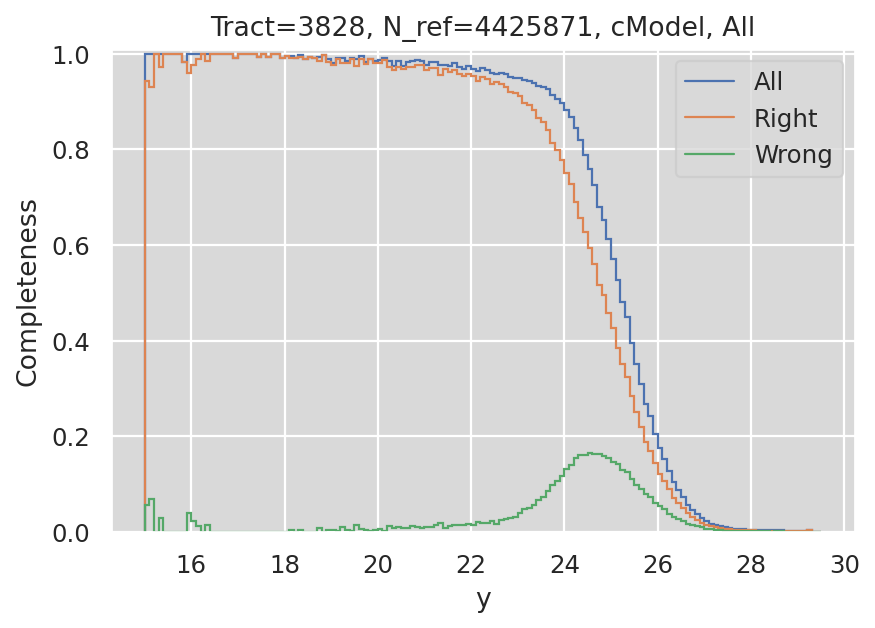

y band, All, Measured


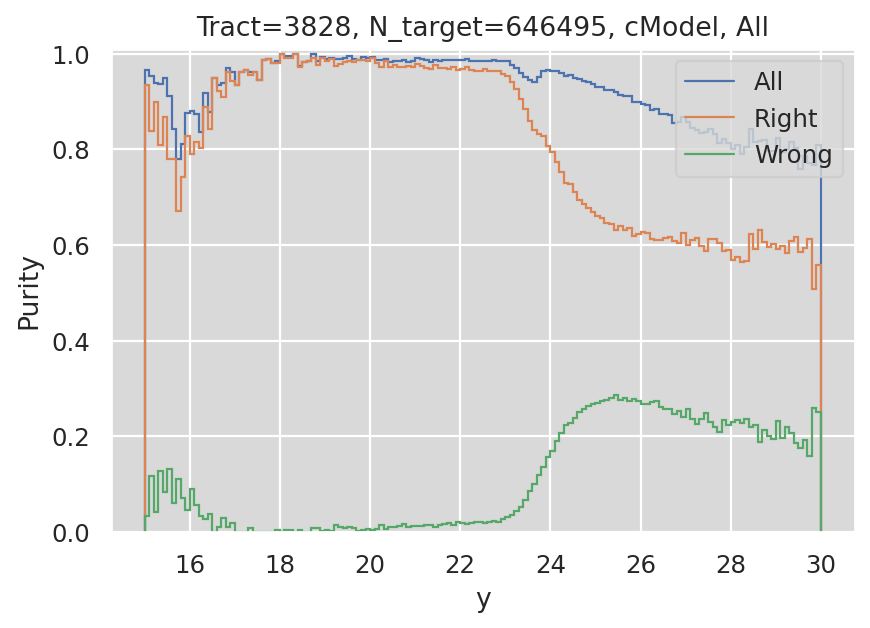

y band, Resolved
y band, Resolved, Reference


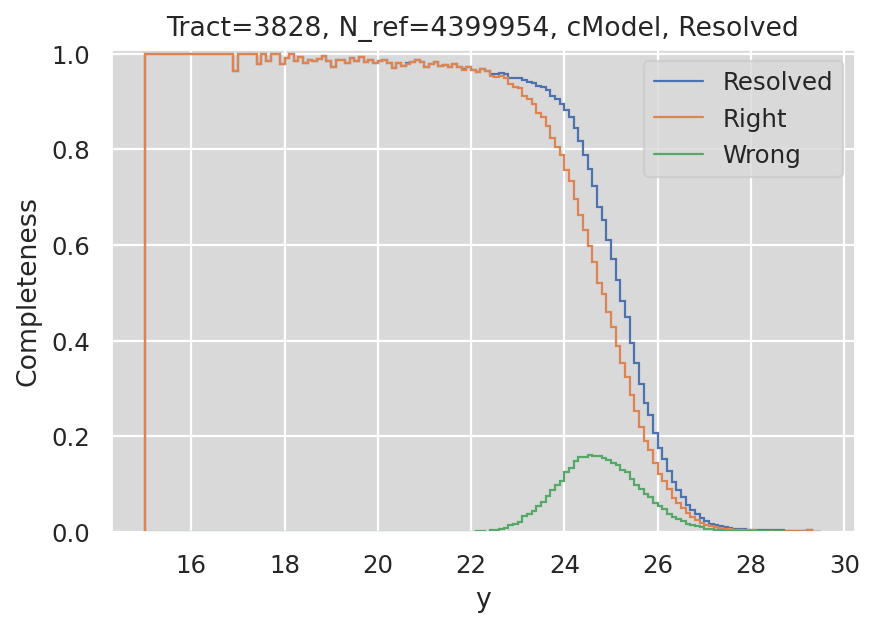

y band, Resolved, Measured


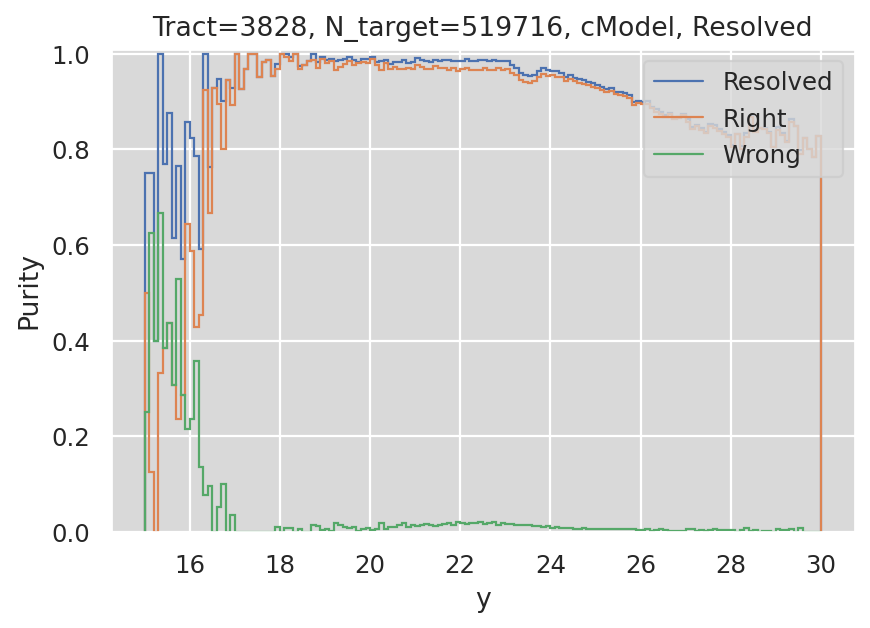

y band, Unresolved
y band, Unresolved, Reference


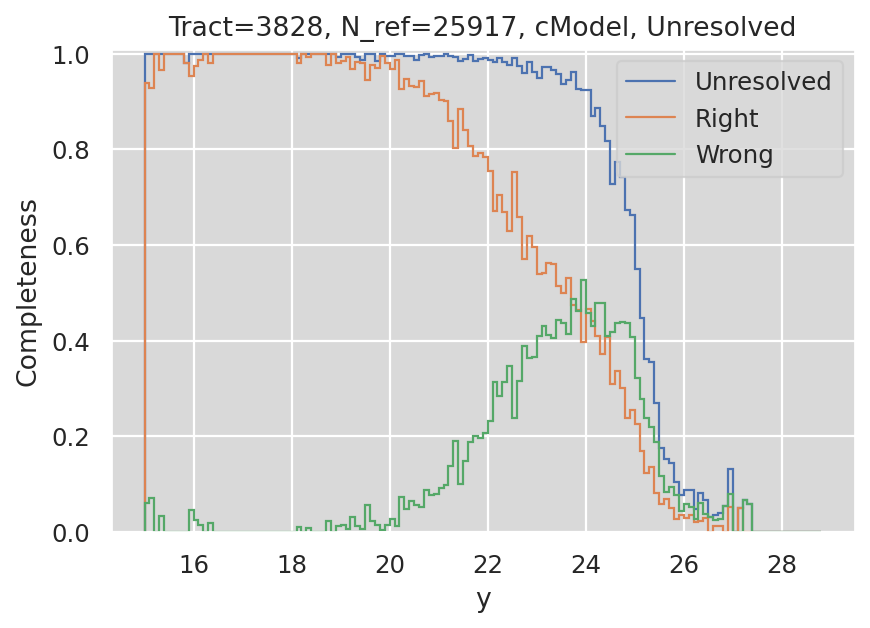

y band, Unresolved, Measured


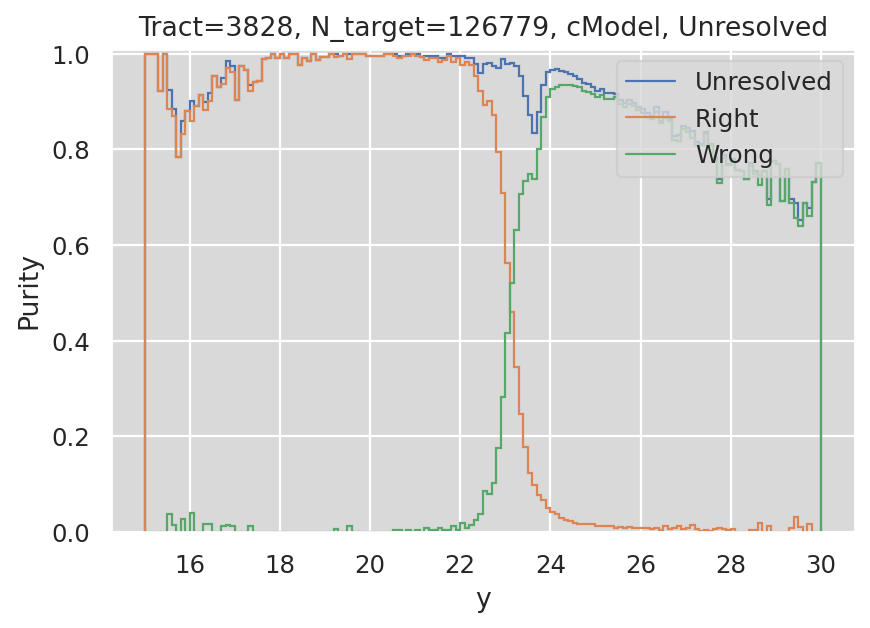

In [8]:
# Plot completeness and purity
for data in data_bins:
    plot_compurity_all(data, bands, sizes, types, matches, tracts[0])

g band


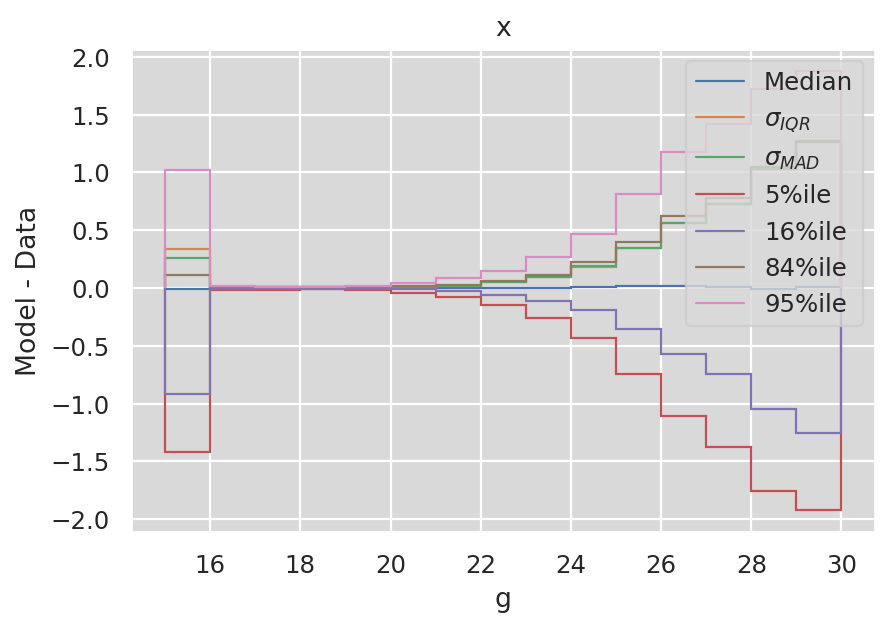

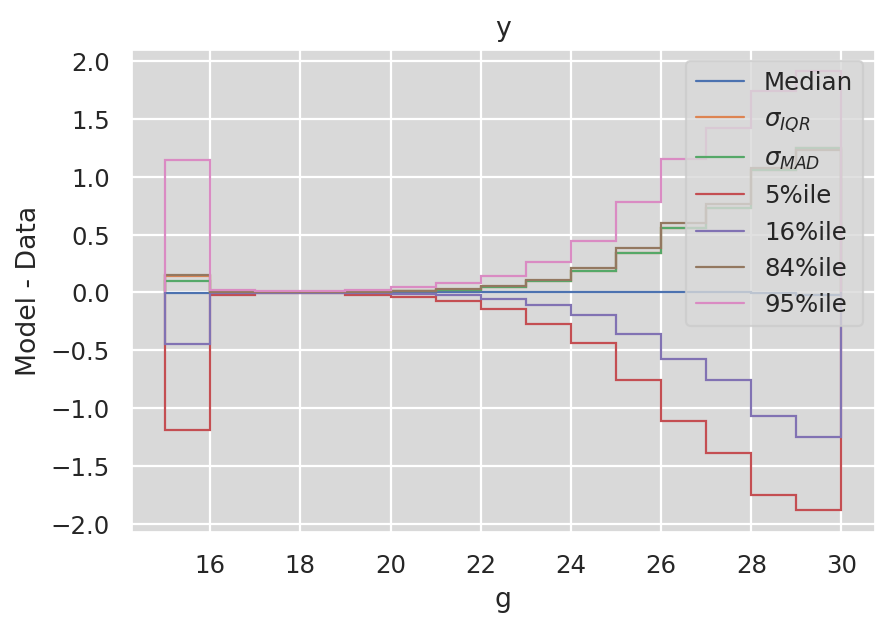

Didn't find g_dr_median
Didn't find g_dr_sig_iqr
Didn't find g_dr_sig_mad
Didn't find g_dr_p05
Didn't find g_dr_p16
Didn't find g_dr_p84
Didn't find g_dr_p95
Didn't find g_flux_g_cModelFlux_median
Didn't find g_flux_g_cModelFlux_sig_iqr
Didn't find g_flux_g_cModelFlux_sig_mad
Didn't find g_flux_g_cModelFlux_p05
Didn't find g_flux_g_cModelFlux_p16
Didn't find g_flux_g_cModelFlux_p84
Didn't find g_flux_g_cModelFlux_p95


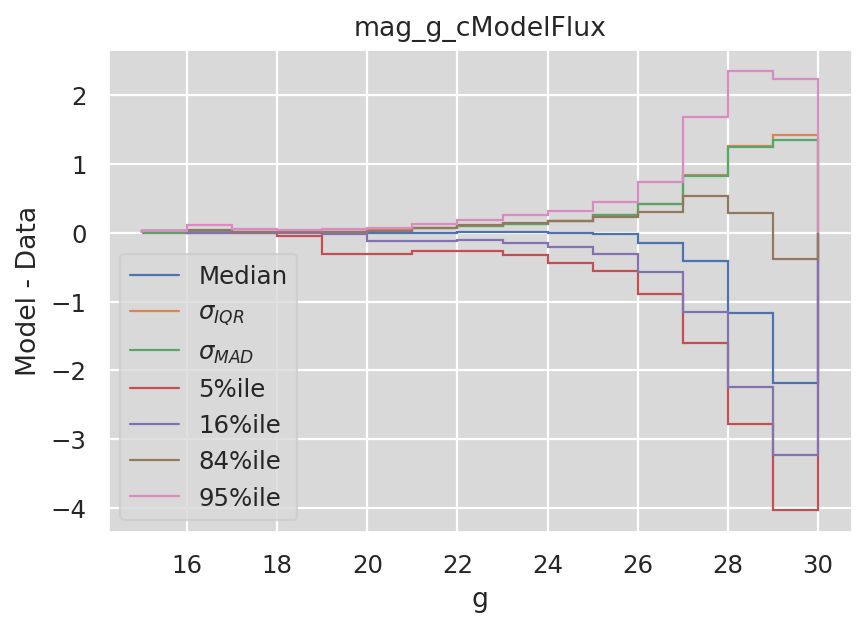

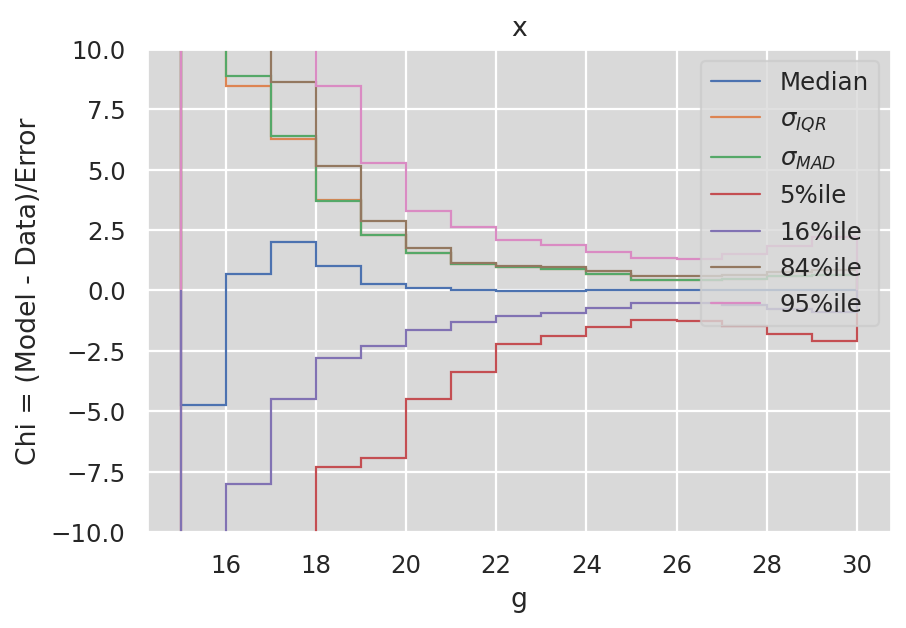

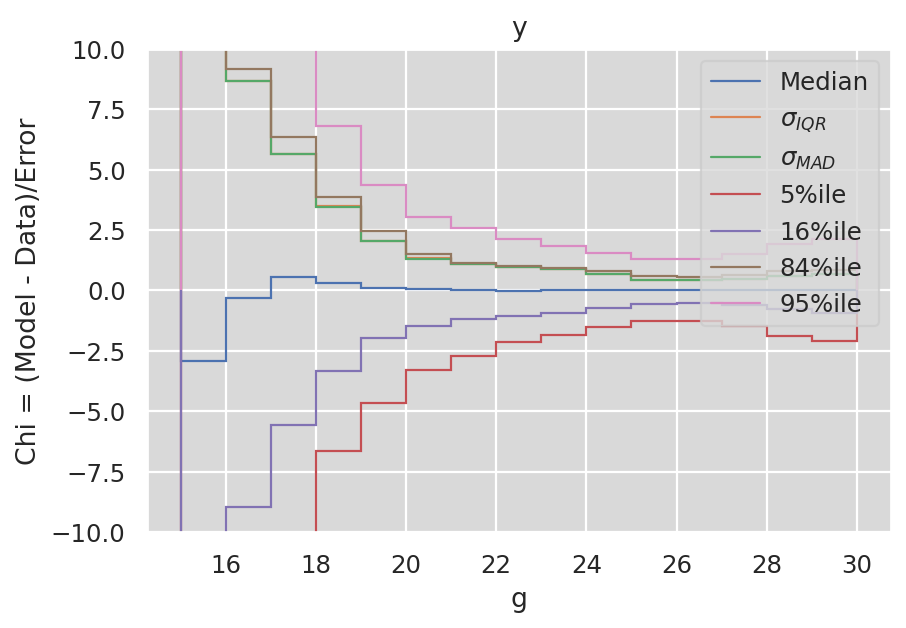

Didn't find g_dr_chi_median
Didn't find g_dr_chi_sig_iqr
Didn't find g_dr_chi_sig_mad
Didn't find g_dr_chi_p05
Didn't find g_dr_chi_p16
Didn't find g_dr_chi_p84
Didn't find g_dr_chi_p95


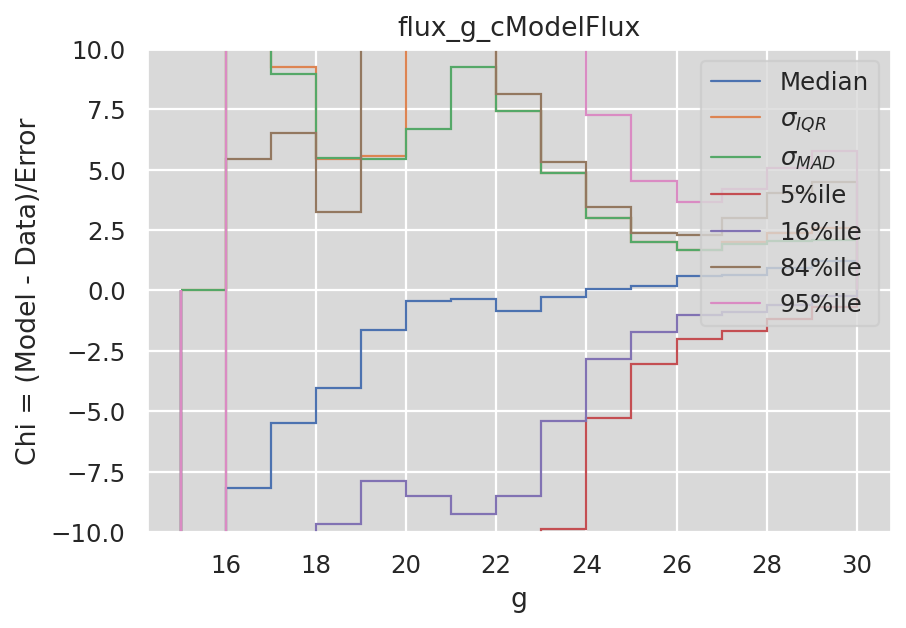

Didn't find g_mag_g_cModelFlux_chi_median
Didn't find g_mag_g_cModelFlux_chi_sig_iqr
Didn't find g_mag_g_cModelFlux_chi_sig_mad
Didn't find g_mag_g_cModelFlux_chi_p05
Didn't find g_mag_g_cModelFlux_chi_p16
Didn't find g_mag_g_cModelFlux_chi_p84
Didn't find g_mag_g_cModelFlux_chi_p95
r band


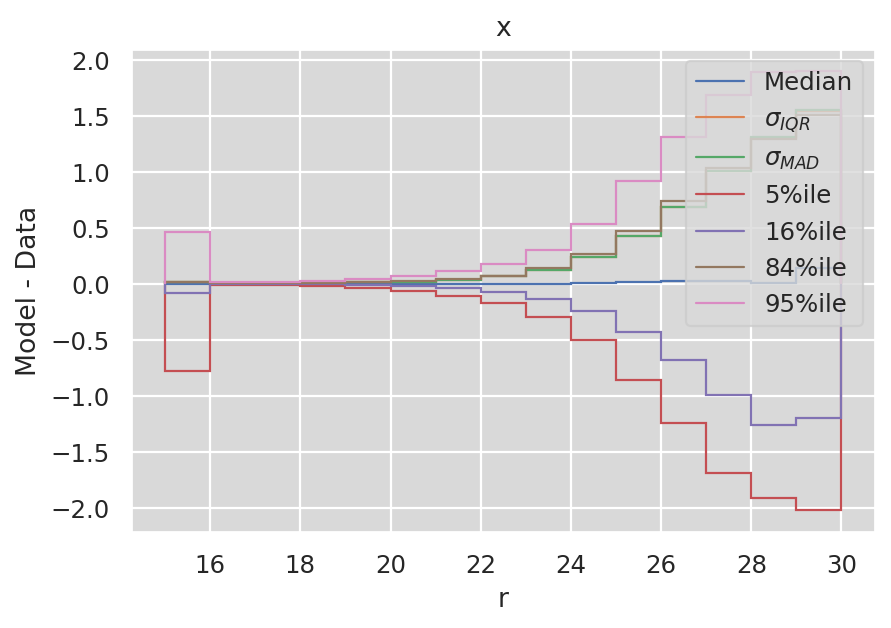

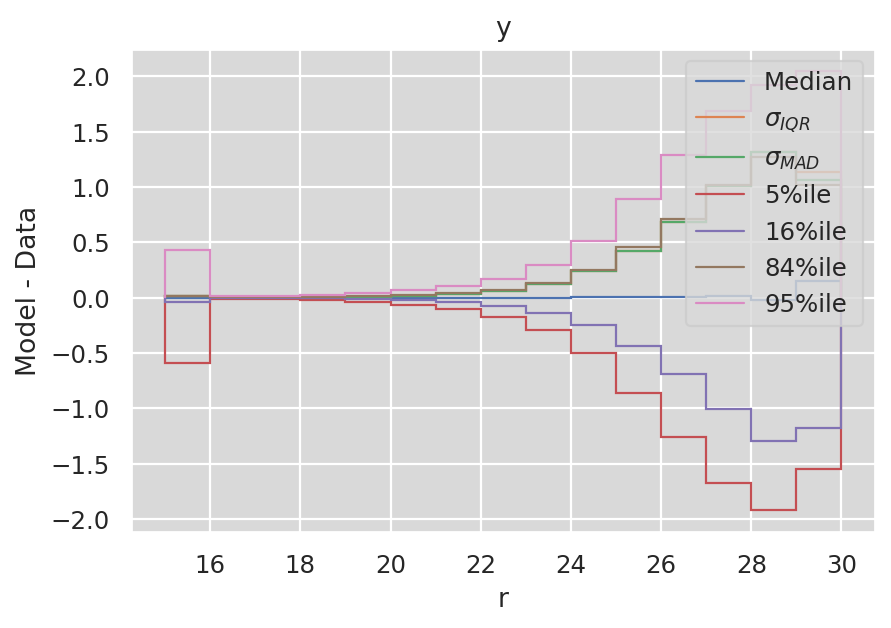

Didn't find r_dr_median
Didn't find r_dr_sig_iqr
Didn't find r_dr_sig_mad
Didn't find r_dr_p05
Didn't find r_dr_p16
Didn't find r_dr_p84
Didn't find r_dr_p95
Didn't find r_flux_r_cModelFlux_median
Didn't find r_flux_r_cModelFlux_sig_iqr
Didn't find r_flux_r_cModelFlux_sig_mad
Didn't find r_flux_r_cModelFlux_p05
Didn't find r_flux_r_cModelFlux_p16
Didn't find r_flux_r_cModelFlux_p84
Didn't find r_flux_r_cModelFlux_p95


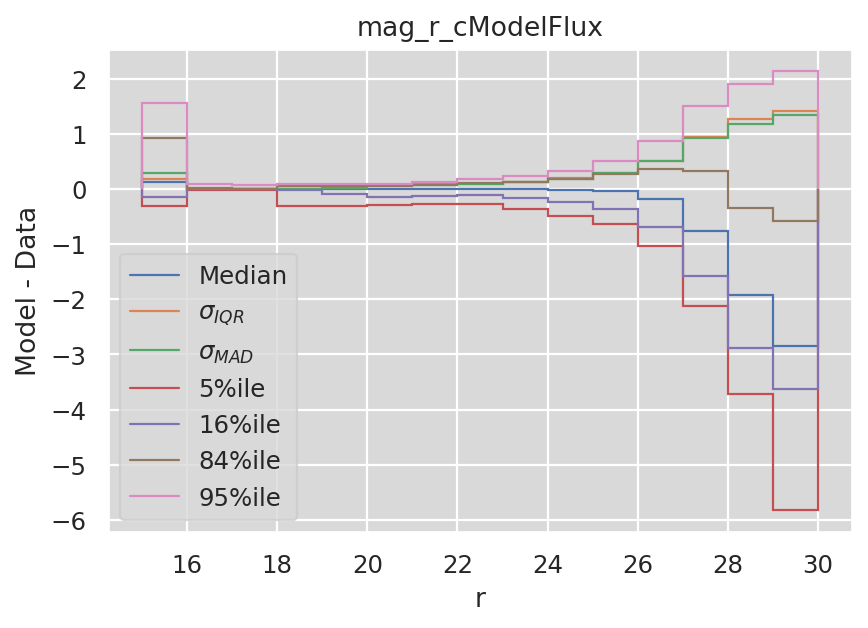

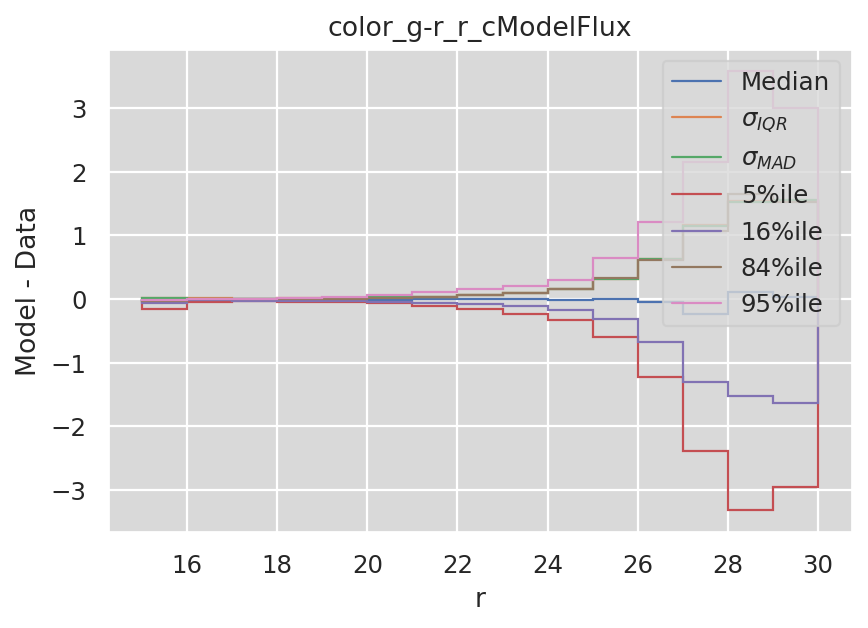

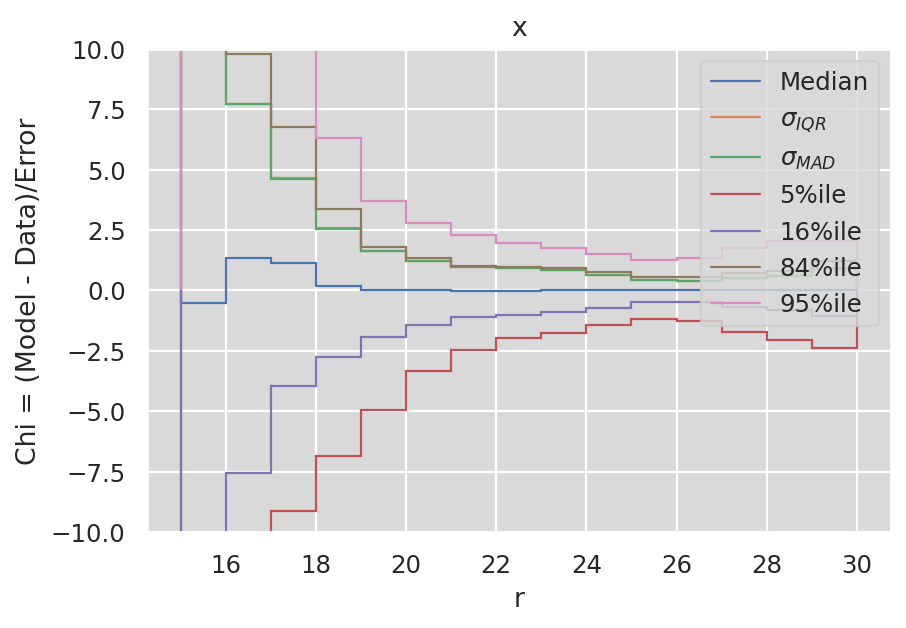

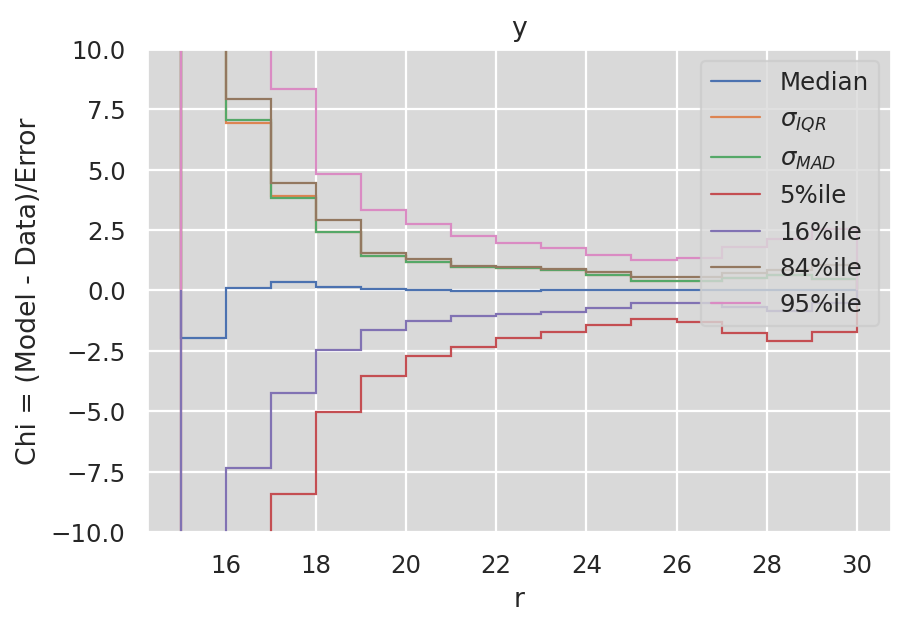

Didn't find r_dr_chi_median
Didn't find r_dr_chi_sig_iqr
Didn't find r_dr_chi_sig_mad
Didn't find r_dr_chi_p05
Didn't find r_dr_chi_p16
Didn't find r_dr_chi_p84
Didn't find r_dr_chi_p95


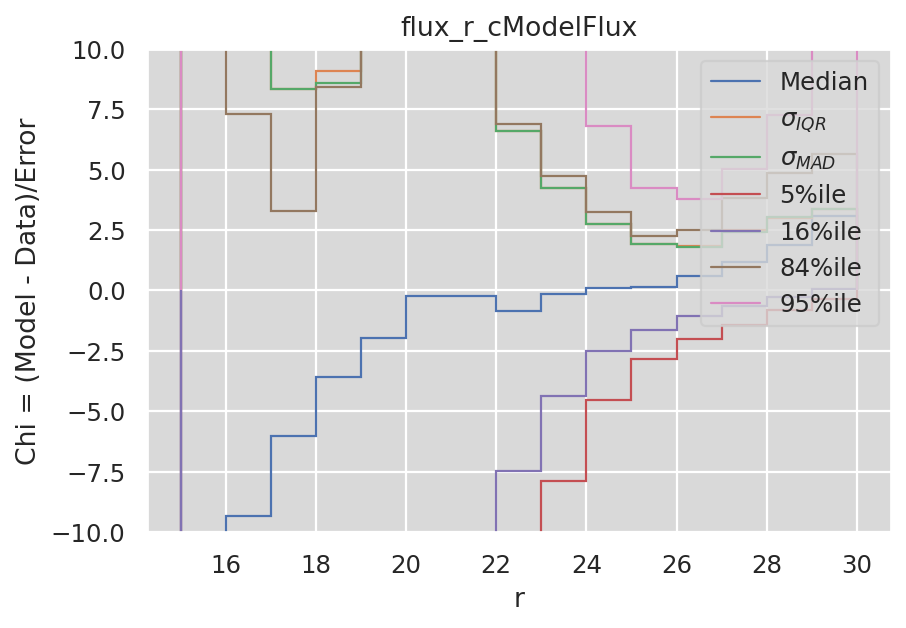

Didn't find r_mag_r_cModelFlux_chi_median
Didn't find r_mag_r_cModelFlux_chi_sig_iqr
Didn't find r_mag_r_cModelFlux_chi_sig_mad
Didn't find r_mag_r_cModelFlux_chi_p05
Didn't find r_mag_r_cModelFlux_chi_p16
Didn't find r_mag_r_cModelFlux_chi_p84
Didn't find r_mag_r_cModelFlux_chi_p95


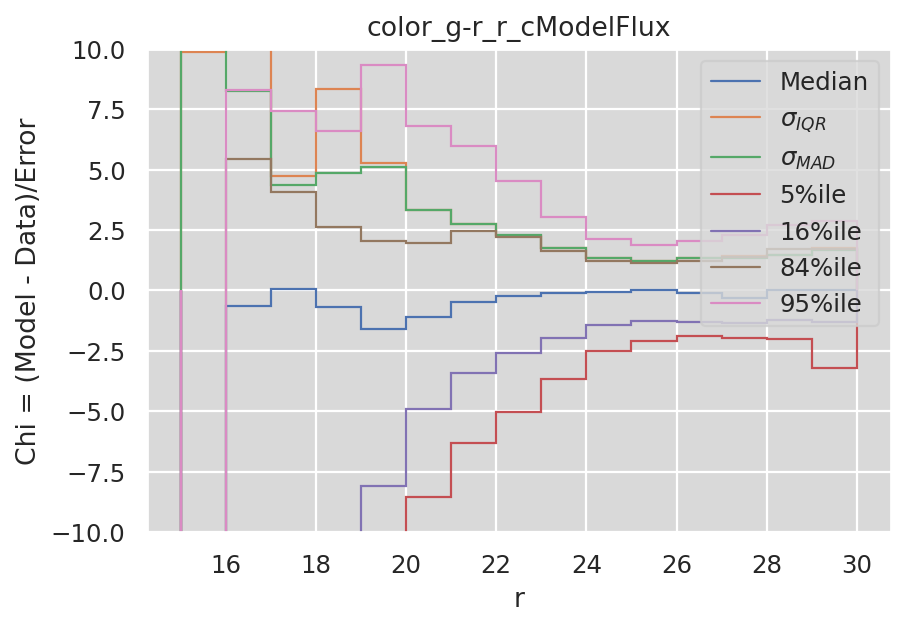

g band


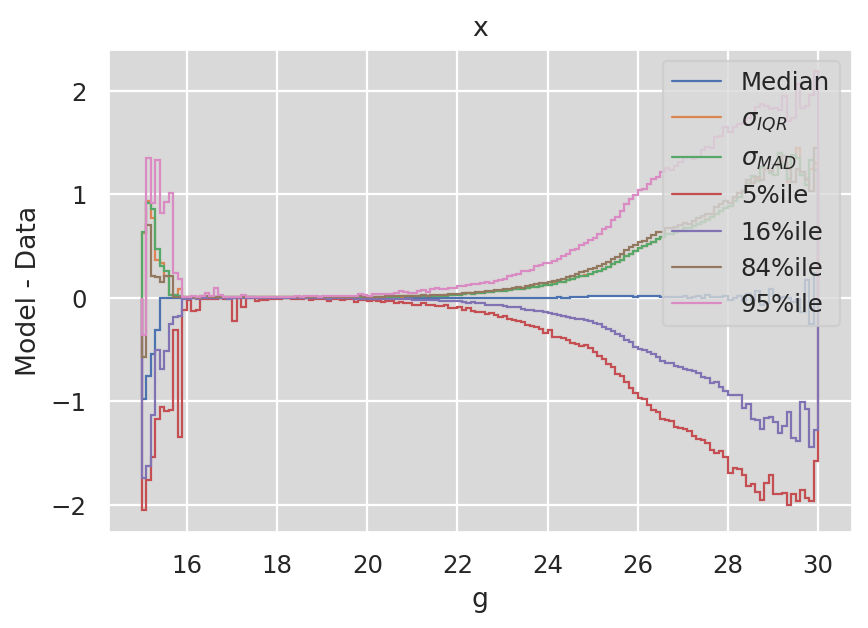

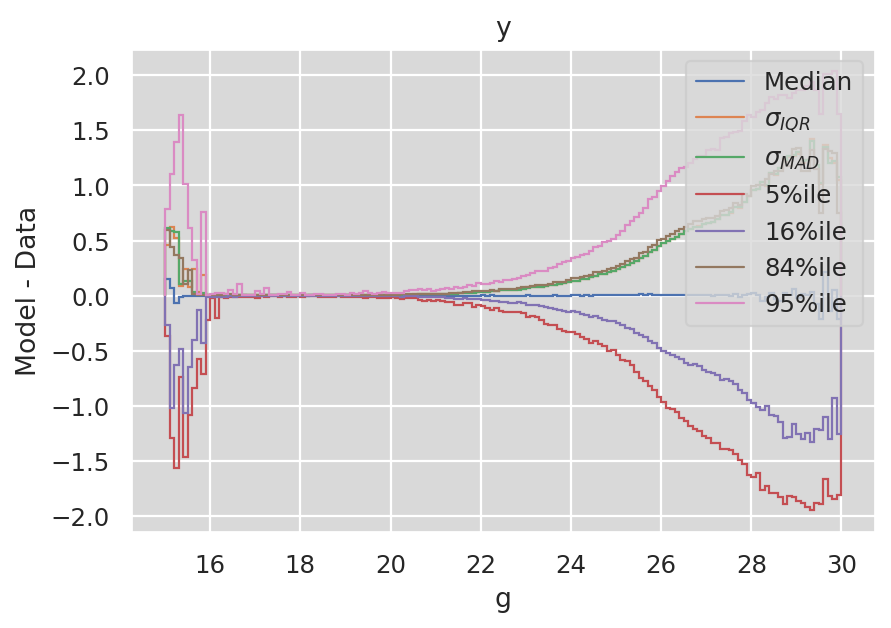

Didn't find g_dr_median
Didn't find g_dr_sig_iqr
Didn't find g_dr_sig_mad
Didn't find g_dr_p05
Didn't find g_dr_p16
Didn't find g_dr_p84
Didn't find g_dr_p95
Didn't find g_flux_g_cModelFlux_median
Didn't find g_flux_g_cModelFlux_sig_iqr
Didn't find g_flux_g_cModelFlux_sig_mad
Didn't find g_flux_g_cModelFlux_p05
Didn't find g_flux_g_cModelFlux_p16
Didn't find g_flux_g_cModelFlux_p84
Didn't find g_flux_g_cModelFlux_p95


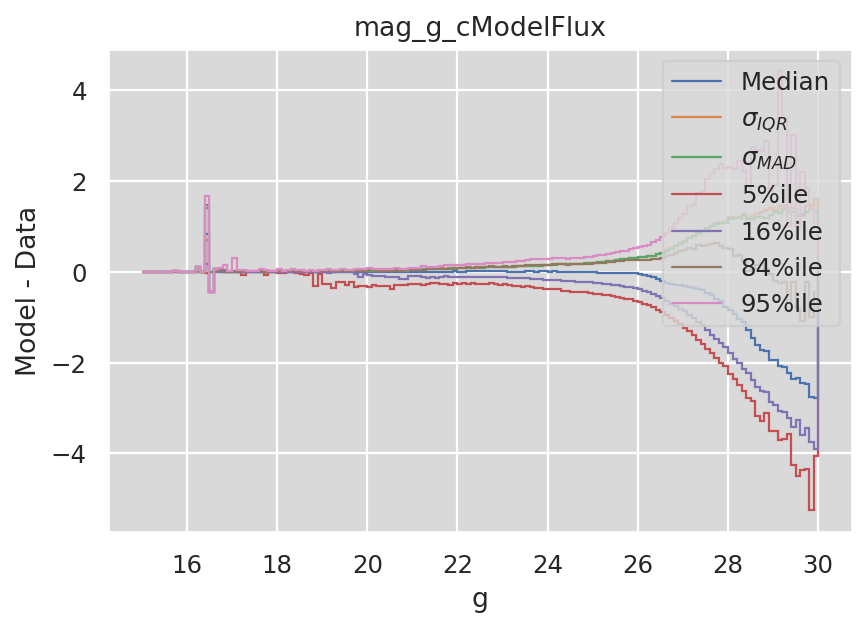

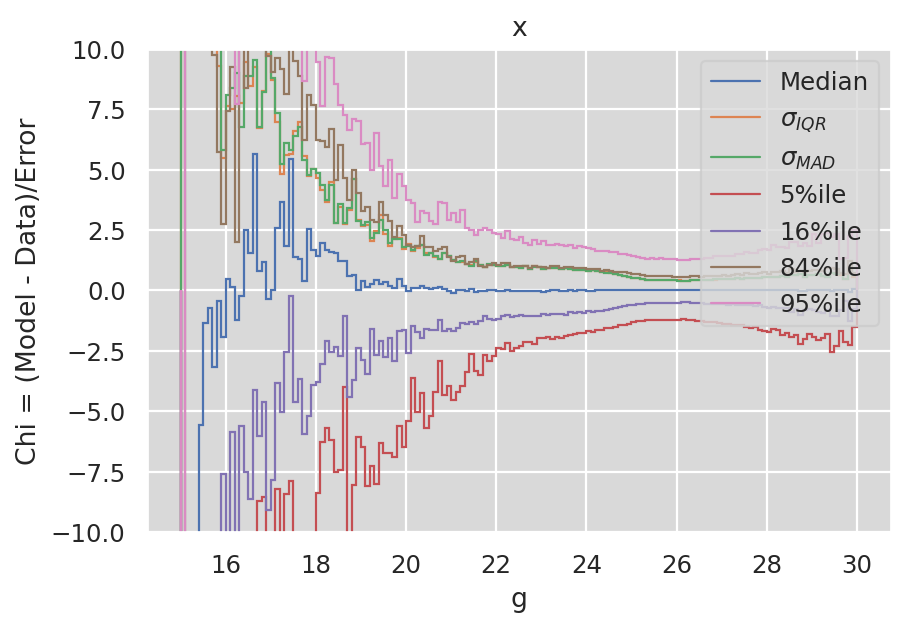

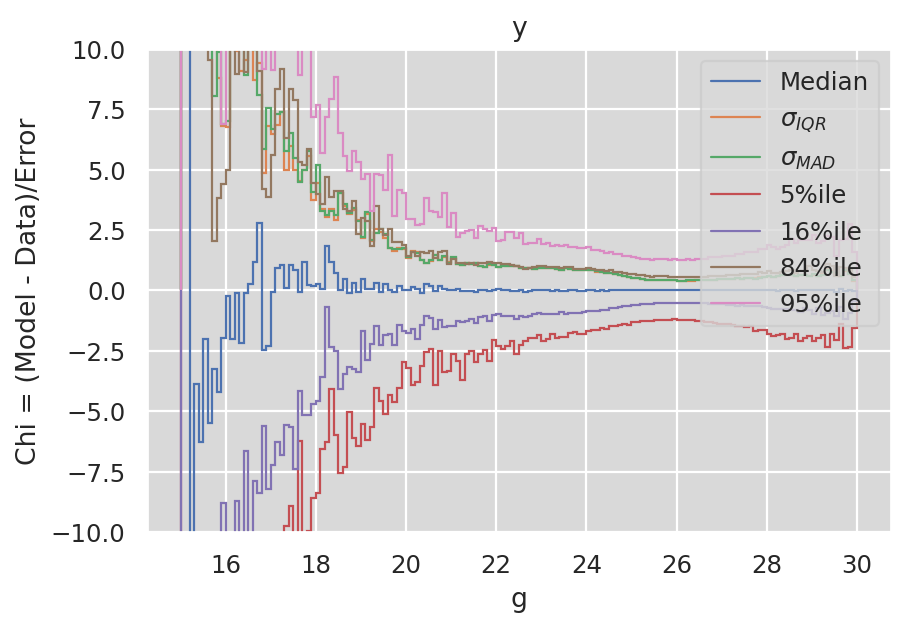

Didn't find g_dr_chi_median
Didn't find g_dr_chi_sig_iqr
Didn't find g_dr_chi_sig_mad
Didn't find g_dr_chi_p05
Didn't find g_dr_chi_p16
Didn't find g_dr_chi_p84
Didn't find g_dr_chi_p95


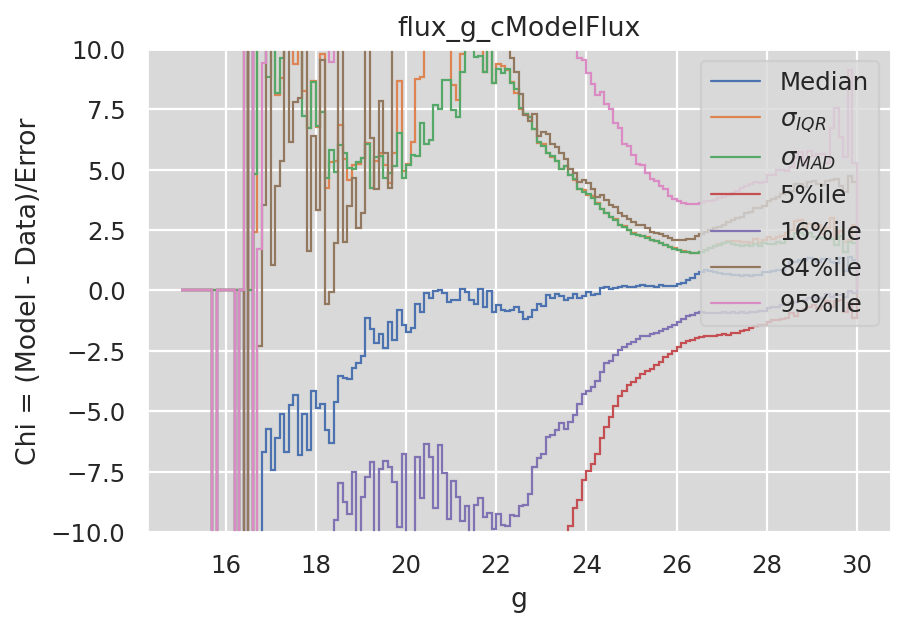

Didn't find g_mag_g_cModelFlux_chi_median
Didn't find g_mag_g_cModelFlux_chi_sig_iqr
Didn't find g_mag_g_cModelFlux_chi_sig_mad
Didn't find g_mag_g_cModelFlux_chi_p05
Didn't find g_mag_g_cModelFlux_chi_p16
Didn't find g_mag_g_cModelFlux_chi_p84
Didn't find g_mag_g_cModelFlux_chi_p95
r band


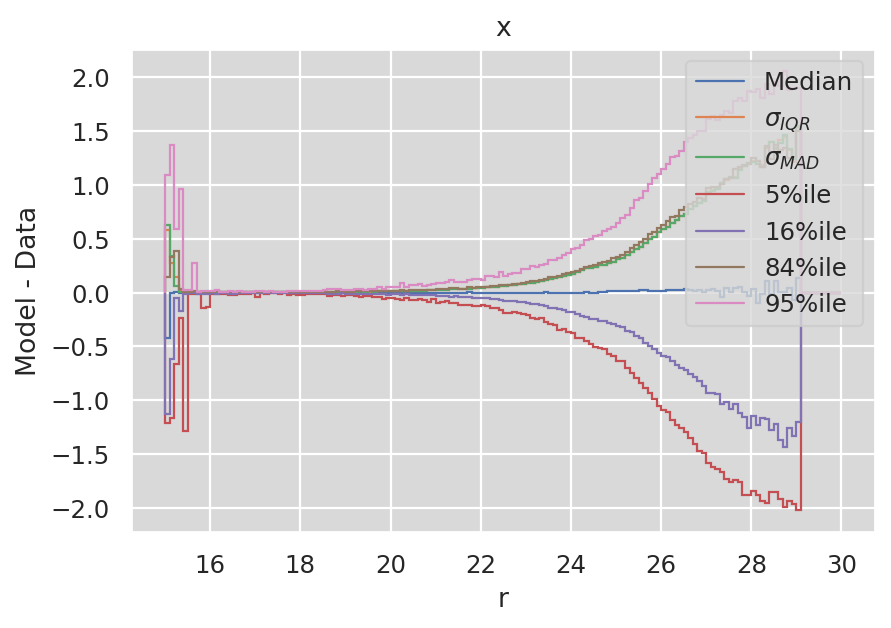

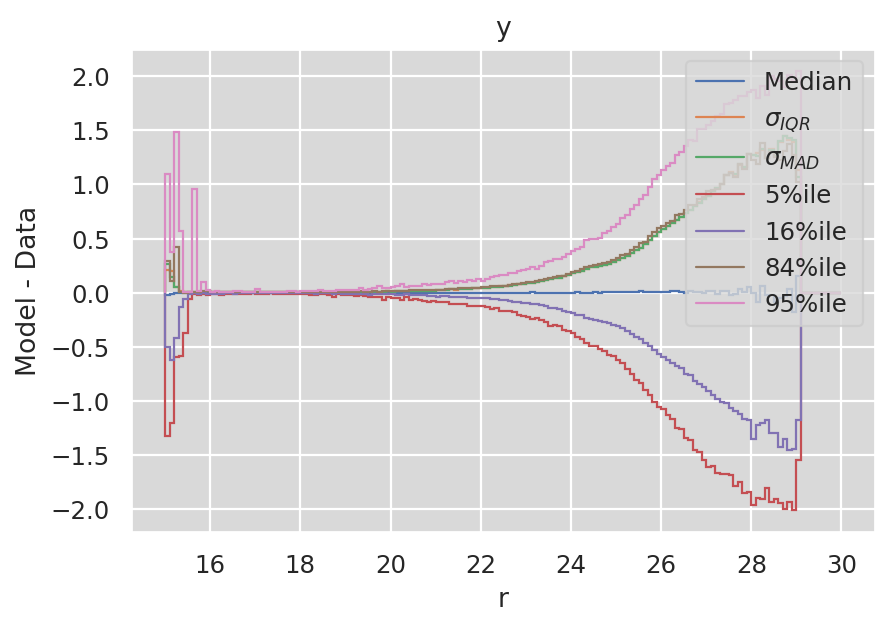

Didn't find r_dr_median
Didn't find r_dr_sig_iqr
Didn't find r_dr_sig_mad
Didn't find r_dr_p05
Didn't find r_dr_p16
Didn't find r_dr_p84
Didn't find r_dr_p95
Didn't find r_flux_r_cModelFlux_median
Didn't find r_flux_r_cModelFlux_sig_iqr
Didn't find r_flux_r_cModelFlux_sig_mad
Didn't find r_flux_r_cModelFlux_p05
Didn't find r_flux_r_cModelFlux_p16
Didn't find r_flux_r_cModelFlux_p84
Didn't find r_flux_r_cModelFlux_p95


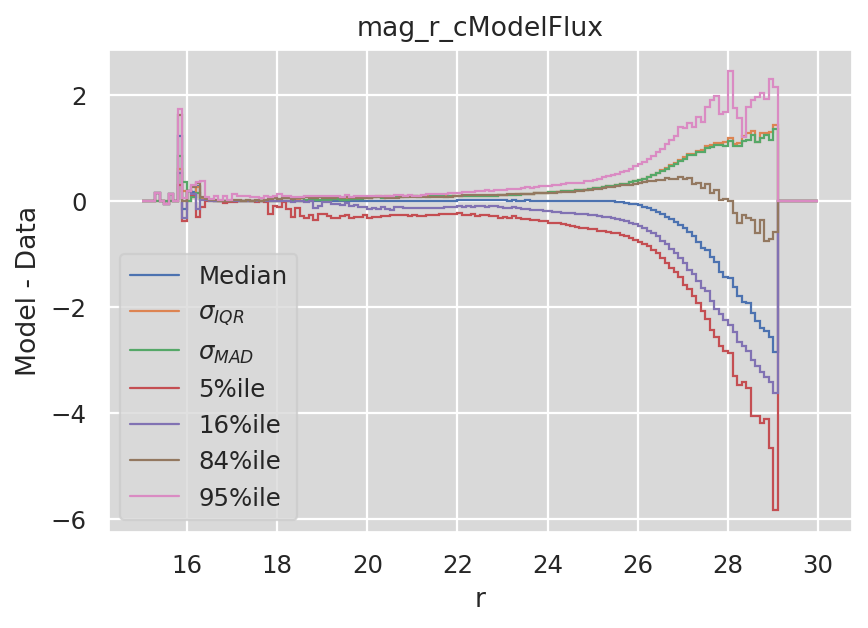

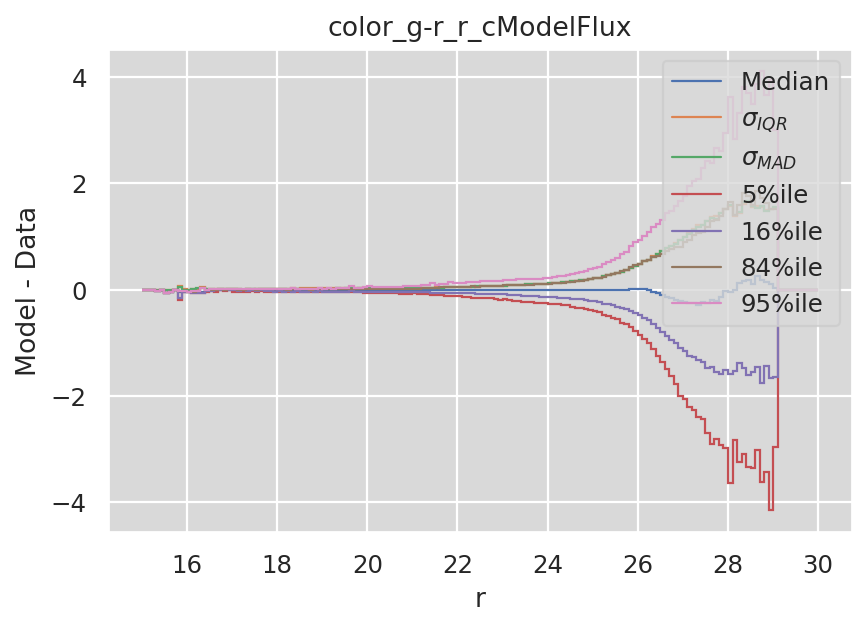

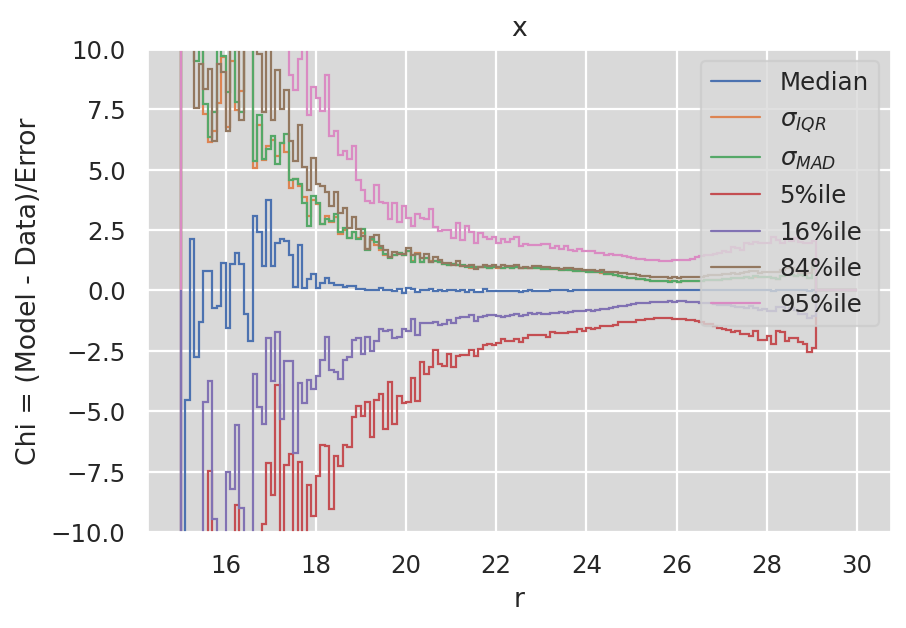

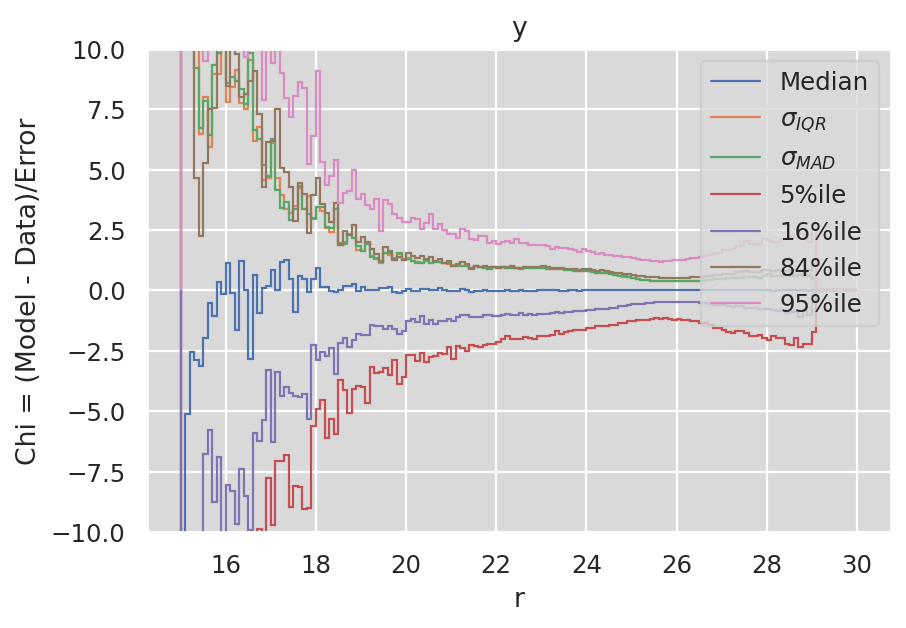

Didn't find r_dr_chi_median
Didn't find r_dr_chi_sig_iqr
Didn't find r_dr_chi_sig_mad
Didn't find r_dr_chi_p05
Didn't find r_dr_chi_p16
Didn't find r_dr_chi_p84
Didn't find r_dr_chi_p95


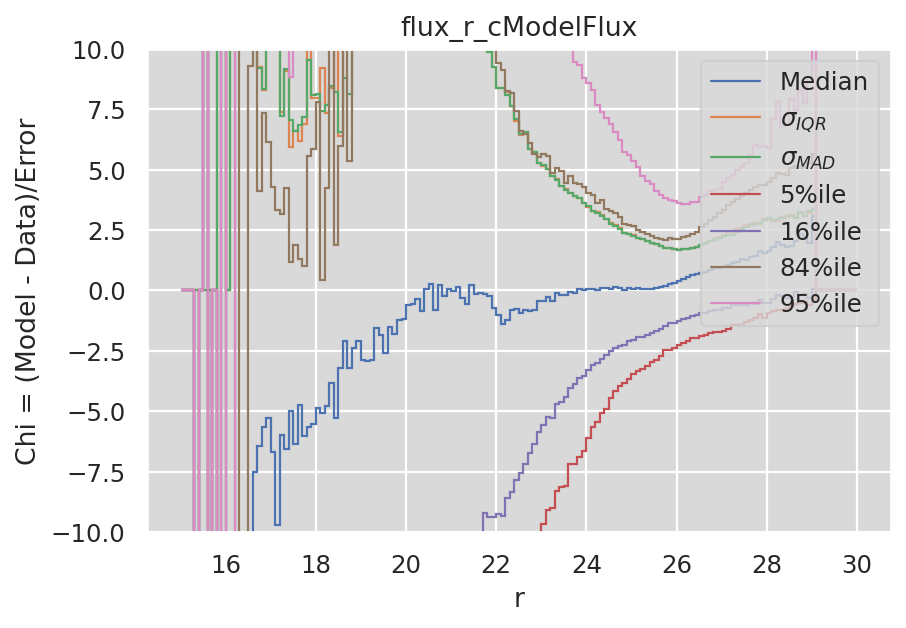

Didn't find r_mag_r_cModelFlux_chi_median
Didn't find r_mag_r_cModelFlux_chi_sig_iqr
Didn't find r_mag_r_cModelFlux_chi_sig_mad
Didn't find r_mag_r_cModelFlux_chi_p05
Didn't find r_mag_r_cModelFlux_chi_p16
Didn't find r_mag_r_cModelFlux_chi_p84
Didn't find r_mag_r_cModelFlux_chi_p95


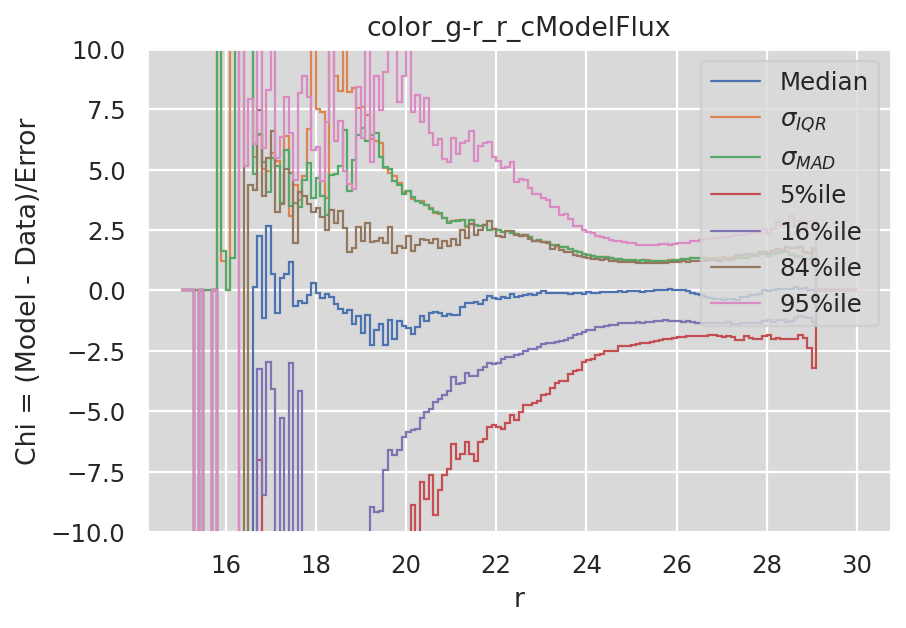

In [9]:
# Plot diffs
for data in data_bins:
    plot_diffs_all(data, 'gr', scales, measures_achrom, stats, model)